<a id='toc'></a>
# Список тестов по бригадам:

1. [Расчет процента подвязки между бригадами и локомотивами.](#perc_assign)
2. [Расчет процента запланированных бригад от общего количества бригад на входе планировщика.](#perc_assign2)
3. [Распределение между реальными и фейковыми бригадами в результатах планирования.](#real_fake)
4. [Составление списка станций и участков, на которых не состоялась подвязка бригады.](#no_assign)
5. [Проверка переработки бригад.](#overwork)   
6. [Проверка "скачков" бригад между станциями.](#leaps)
7. [Анализ времен стоянок поездов для смены бригады.](#stop_time)
8. [Анализ времен отдыха бригад.](#rest_time)
9. [Проверка корректности времен явки бригад во входных данных](#ready_time)
10. [Проверка смены бригад на корректных станциях](#change)
11. [Проверка отправления бригад до времени явки](#presence)
12. [Проверка планирования бригад до времени начала планирования](#before_current_time)
13. [Проверка планируемых явок бригад](#presenting)
14. [Проверка использования бригад после засылки пассажирами](#check_useful_assign)
  1. [Бригады, бесцельно отправляемые пассажирами](#only_pass)
  2. [Бригады, у которых запланирована только явка](#only_presence)
15. [Проверка подвязки негрузовых бригад](#pass_teams_in_plan)
16. [Проверка сохранения предыдущих времен явок](#Проверка-сохранения-предыдущих-времен-явок)
17. [Проверка возврата правильных времен явок у бригад](#Проверка-возврата-правильных-времен-явок-у-бригад)
18. [Проверка планирования УТХ бригад](#Проверка-планирования-УТХ-бригад)
  1. [Сравнение времен отправления и явок УТХ- и не-УТХ-бригад](#cmp_depart_uth)
  2. [Детальная проверка планирования УТХ-бригад по одной станции](#uth_detail)
  3. [Проверка отсутствия сдвига явки для бригад из депо, по которым нет УТХ-планирования](#no_uth)

### Константы и настройки

In [708]:
report = ''               # здесь будет храниться весь html-код отчета
FOLDER = 'resources/'     # папка с csv-файлами с данными
REPORT_FOLDER = 'report/' # папка для отчетов
PRINT = True              # выводить ли все таблицы из отчета на печать здесь в блокноте

In [709]:
TIME_FORMAT = '%b %d, %H:%M'
'''
    Преобразует время из timestamp в красивый формат, заданный в константе time_format
'''
def nice_time(t):
    return time.strftime(TIME_FORMAT, time.localtime(t)) if t > 0 else ''

def nice_print(s, **kwargs):    
    num = kwargs['num'] if 'num' in kwargs.keys() else False
    cols = kwargs['cols'] if 'cols' in kwargs.keys() else s.columns
    if num:
        print(s.reset_index()[cols].to_string())
    else:
        print(s[cols].to_string(index=False))

### Функции для экспорта в HTML

In [710]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="30%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [711]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv')
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                     'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str,
                                                                     'state':str})
# Может показаться странным, что атрибут state тоже парсится как string. Это сделано, чтобы не возникало проблем с парсингом 
# кривых данных в state (например, если state не указан вообще).

team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Время составления отчета:', time.strftime(TIME_FORMAT, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (nice_time(current_time), current_time))

Время составления отчета: Aug 17, 17:08
Время запуска планировщика: Aug 16, 19:31 (1471365082)


In [712]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_f'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_f'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] != '7' else 'Фейковая')

In [713]:
add_line('Время сбора данных и запуска планировщика: %s' % nice_time(current_time))

Время сбора данных и запуска планировщика: Aug 16, 19:31


<a id='perc_assign'></a>
## Расчет процента подвязки между локомотивами и бригадами [ToC](#toc)

Для каждого локомотива берется маршрут на нужном горизонте и на каждом участке маршрута проверяется, подвязана ли к локомотиву бригада на этом участке. Если хотя бы на одном участке бригады нет, то локомотив считается "плохим". На выходе рассчитывается процент "хороших" локомотивов от общего числа.

Отдельно считаются проценты локомотивов, обеспеченных реальными (не фейковыми) бригадами.

In [714]:
add_header('Расчет процента подвязки между локомотивами и бригадами', h=2, p=False)

In [715]:
def count_real_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             ((loco_plan.team == -1) | (loco_plan.team_type == 'Фейковая')) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без реальных бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    
    
def count_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             (loco_plan.team == -1) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    count_real_assign_percent(hor)   

    
if 'team' not in loco_plan.columns:
    loco_plan = loco_plan.set_index(['loco', 'time_start']).join(team_plan.loc[team_plan.state == 1, \
                                                                ['team', 'loco', 'time_start', 'team_type']].\
                                                                 set_index(['loco', 'time_start'])).reset_index()    
    loco_plan.team.fillna(-1, inplace=True)

count_assign_percent(6 * 3600)
count_assign_percent(12 * 3600)
count_assign_percent(24 * 3600)

Локомотивов без бригад на горизонте  6 часов: 41 из 1509 (процент подвязки 97%)
Локомотивов без реальных бригад на горизонте  6 часов: 133 из 1509 (процент подвязки 91%)
Локомотивов без бригад на горизонте 12 часов: 70 из 1509 (процент подвязки 95%)
Локомотивов без реальных бригад на горизонте 12 часов: 306 из 1509 (процент подвязки 79%)
Локомотивов без бригад на горизонте 24 часов: 140 из 1509 (процент подвязки 90%)
Локомотивов без реальных бригад на горизонте 24 часов: 604 из 1509 (процент подвязки 59%)


<a id='perc_assign2'></a>
## Расчет процента запланированных бригад от общего количества [ToC](#toc)

Тест показывает, какая доля от реальных бригад, поданных на вход планировщика, использовалась в планировании (= есть в результатах планирования). Отдельно показываются доли по всем входным состояниям бригад.

Хорошим считается планирование, когда по всем состояниям, кроме 3 и 9, доля использованных реальных бригад высока. Для бригад в состояниях 3 ("находится на домашнем отдыхе") и 9 ("сдача локомотива в депо") допускается низкий процент использования.

In [716]:
add_header('Расчет процента запланированных бригад от общего количества бригад на входе', h=2, p=False)

Всего бригад, запланированных с локомотивами в работе: 3285 из 4816 (68.21%)


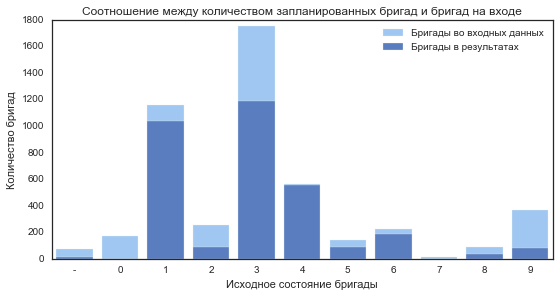

In [717]:
team_assigned_n = team_info[team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)]\
                    .drop_duplicates('team').team.count()
team_total_n = team_info.drop_duplicates('team').team.count()
team_assigned_percent = team_assigned_n / team_total_n
add_line('Всего бригад, запланированных с локомотивами в работе: %d из %d (%.2f%%)' %
      (team_assigned_n, team_total_n, 100 * team_assigned_percent))
team_info['is_assign'] = team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)
assign_states = team_info.loc[team_info.is_assign == True, ['team', 'state']].state.value_counts().to_frame()
initial_states = team_info.state.value_counts().to_frame()
initial_states.columns=['Бригады во входных данных']
assign_states.columns=['Бригады в результатах']
states = initial_states.join(assign_states)
states.fillna(0, inplace=True)

sns.set(style='white', context='notebook')
sns.set_color_codes('pastel')
fig = plt.figure(figsize=(8, 4))
sns.barplot(x='index', y='Бригады во входных данных', data=states.sort_index().reset_index(), 
            color="b", label='Бригады во входных данных')
sns.set_color_codes('muted')
ax = sns.barplot(x='index', y='Бригады в результатах', data=states.sort_index().reset_index(), 
            color="b", label='Бригады в результатах')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylabel='Количество бригад', xlabel='Исходное состояние бригады', 
       title='Соотношение между количеством запланированных бригад и бригад на входе')
#sns.despine()
filename = 'team_usage.png'
plt.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='real_fake'></a>
### Распределение реальных и фейковых бригад в результатах планирования

Доля фейковых бригад должна быть небольшой. На текущий момент (15.08.2016) на нормальном расчете доля фейковых бригад составляет 20-25%. В дальнейшем эту долю надо уменьшать.

In [718]:
add_header('Распределение реальных и фейковых бригад в результатах планирования', h=2, p=False)

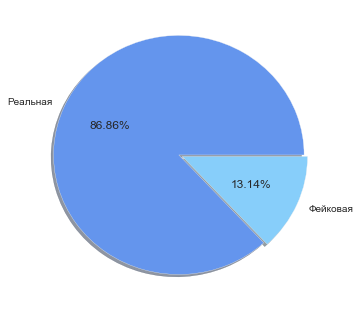

In [719]:
f = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').team_type.value_counts()
fig = plt.figure(figsize=(5,5))
colors = ['cornflowerblue', 'lightskyblue']
expl = (0.03, 0) if len(f) == 2 else None
plt.pie(f, autopct='%.2f%%', colors=colors, explode=expl, shadow=True, labels=list(f.index))
filename = 'real_fake_teams_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='no_assign'></a>
## Cтанции и участки, на которых не состоялась подвязка бригады [ToC](#toc)

Тест выявляет участки, на которых чаще всего не происходила подвязка бригады. "Участком" в данном случае является первый участок на маршруте какого-то локомотива, на котором не состоялась подвязка бригады (любой - реальной или фейковой). 

По состоянию на 15.08 станция Зыково не принадлежала ни одному участку обкатки бригад, так что наличие участков с этой станцией в списке объяснимо. По остальным участкам требуется расследование: вообще, случаев неподвязки бригад быть не должно, всегда должна создаваться либо реальная, либо фейковая бригада.

In [720]:
add_header('Станции и участки, на которых не состоялась подвязка бригады', h=2, p=False)

In [721]:
horizon = 6 * 3600
add_line('Горизонт анализа: %d часов' % (horizon / 3600), p=False)
loco_mask = (loco_plan.time_start < current_time + horizon)

In [722]:
# Добавляем признак первой станции на маршруте локомотива, где не была подвязана бригада
loco_plan.loc[loco_plan.state == 4, 'team'] = 0
loco_plan['no_team_start'] = (loco_plan.team == -1) & \
                             ((loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1)))
    
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'team', 'no_team_start']
fail_team_assign_locos = loco_plan.loc[loco_mask & (loco_plan.no_team_start == True)]
if not fail_team_assign_locos.empty:
    fail_team_assign_stations = fail_team_assign_locos.st_from_name.value_counts().head(10)
    fail_team_assign_tracks = fail_team_assign_locos.groupby('st_from_name').st_to_name.value_counts().\
                                sort_values(ascending=False).head(10)
    add_header('Станции, на которых не удалось подвязать бригады под локомотив (первые 10):')
    add_line(fail_team_assign_stations)
    add_header('\nУчастки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):')
    add_line(fail_team_assign_tracks)
    st_name = fail_team_assign_stations.head(1).index[0]
    bad_locos = loco_plan.loc[loco_mask & (loco_plan.st_from_name == st_name) & (loco_plan.no_team_start == True)]
    if not bad_locos.empty:
        add_header('Локомотивы, к которым не была подвязана бригада на станции %s, по направлениям:' % st_name)
        add_line(bad_locos.st_to_name.value_counts())
else:
    print('Подвязка бригад под локомотивы выполнена на всех станциях')

Станции, на которых не удалось подвязать бригады под локомотив (первые 10):
КРАСНОЯРСК-ВОСТОЧНЫЙ                  14
УЯР                                   11
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ     8
АМАЗАР                                 1
ЕРОФЕЙ ПАВЛОВИЧ                        1
КОМСОМОЛЬСК-НА-АМУРЕ                   1
ДЗЕМГИ                                 1
КАРЫМСКАЯ                              1
КРАСНОЯРСК-СЕВЕРНЫЙ                    1
МИНУСИНСК                              1

Участки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):
st_from_name                        st_to_name          
КРАСНОЯРСК-ВОСТОЧНЫЙ                ЗЫКОВО                  14
УЯР                                 ЗЫКОВО                  11
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  СЕЛИХИН                  4
                                    КОМСОМОЛЬСК-НА-АМУРЕ     4
НОВЫЙ УРГАЛ                         УРГАЛ I                  1
МИНУСИНСК                           КУРАГИНО        

<a id='overwork'></a>
## Проверка переработки бригад [ToC](#toc)

Сложный и не всегда корректно срабатывающий тест.

Тест проверяет планы по бригадам на переработки. Для этого сначала для каждого участка на маршруте бригады определяется время последней операции явки до этого участка. Это может быть либо явка, переданная во входных данных, либо явка, запланированная планировщиком (явка - это участок маршрута со state = 2). 

Затем составляется таблица с поездками бригад - фрагментами маршрутов, на которых у бригады не происходило смены локомотива или изменения состояния.

Далее для каждой поездки считается время работы. Оно не должно превышать нормативное рабочее время, заданное в сообщениях `team_region`. Для каждой поездки вычисляется время переработки.

**TODO:** Здесь есть пробел в логике: по идее, за один цикл работы от выхода до отдыха бригада может несколько раз сменить локомотив или состояние. Например, она может поехать сначала на один маленький участок с одним локомотивом, там пересесть на другой локомотив и поехать, скажем, в том же направлении дальше. И только когда-то потом уйти на отдых. Видимо, правильнее будет определять фрагменты маршрутов бригад между явкой и отдыхом (и от явки до конца маршрута, если отдыха до конца маршрута нет) и считать время хода на таких фрагментах.

In [723]:
add_header('Бригады с переработкой', h=2, p=False)

#### Вычисляем последнее время явки для каждого участка на маршруте

In [724]:
# В поле presence прописываем последнюю явку бригады из входных данных
team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: max(x))
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['info_presence'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').presence)
team_plan['info_presence_norm'] = team_plan.info_presence.apply(nice_time)
team_plan['info_presence'] = team_plan.info_presence.apply(lambda x: [] if np.isnan(x) else [int(x)])

# Собираем все запланированные явки бригады. 
# Если ни одной явки не запланировано, то проставляем фейковые явки: время первого отправления (после отдыха) минус 1 час
team_plan['start_trip'] = team_plan.state.isin([0, 1]) \
                & ((team_plan.team != team_plan.team.shift(1)) | (team_plan.state.shift(1) == 4))
team_plan['fake_plan_presence'] = team_plan.team.map(team_plan[team_plan.start_trip].groupby('team').time_start.unique() - 3600)
team_plan.fake_plan_presence.fillna(0, inplace=True)
team_plan['fake_plan_presence'] = team_plan.fake_plan_presence.apply(lambda x: [] if (type(x) == int) else x)
team_plan['plan_presence'] = team_plan.team.map(team_plan[team_plan.state == 2].groupby('team').time_start.unique())
team_plan.plan_presence.fillna(0, inplace=True)
team_plan['plan_presence'] = team_plan.plan_presence.apply(lambda x: [] if (type(x) == int) else x)

In [725]:
def get_curr_presence(row):
    real_presence = np.concatenate([row.info_presence, row.plan_presence])   
    if len(real_presence) > 0:
        presence_list = real_presence
    elif len(row.fake_plan_presence) > 0:
        presence_list = row.fake_plan_presence
    else:
        return current_time
        
    t = row.time_start
    b = [x for x in presence_list if x <= t]
    return int(max(b)) if b != [] else (row.fake_plan_presence[0] if len(row.fake_plan_presence) > 0 else current_time)   
    
    
team_plan['curr_presence'] = team_plan.apply(lambda row: get_curr_presence(row), axis=1)
#cols = ['team', 'st_from_name', 'time_start', 'state', 'info_presence', 'info_presence_norm', 
#        'plan_presence', 'fake_plan_presence', 'curr_presence']
#team_plan[team_plan.team == '777700001868'][cols]

#### Составляем таблицу team_trips с поездками бригад

In [726]:
cols = ['team', 'state', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'loco', 'start_trip', 'end_trip', 
        'start_trip_time', 'end_trip_time']
team_plan['end_trip'] = ((team_plan.team != team_plan.team.shift(-1)) & (team_plan.state == 1)) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(-1).isin([0, 2, 4])))
team_plan.loc[team_plan.end_trip == True, 'end_trip_time'] = team_plan.time_end
team_plan['start_trip'] = ((team_plan.state == 1) & (team_plan.team != team_plan.team.shift(1))) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(1).isin([0, 2, 4])))
team_plan.loc[team_plan.start_trip == True, 'start_trip_time'] = team_plan.time_start
start_trips = team_plan.dropna(subset=['start_trip_time'])
end_trips = team_plan.dropna(subset=['end_trip_time'])

frames = [start_trips.reset_index()[['team', 'state', 'st_from_name', 'start_trip_time']],
          end_trips.reset_index()[['st_to_name', 'end_trip_time', 'curr_presence']]]
team_trips = pd.concat(frames, axis=1, ignore_index=True)
team_trips.columns = ['team', 'state', 'st_from_name', 'time_start', 'st_to_name', 'time_end', 'curr_presence']
add_info(team_trips)
team_trips['curr_presence_norm'] = team_trips.curr_presence.apply(nice_time)

#### Загружаем нормы рабочего времени и составляем таблицу по нормам для каждой бригады

In [727]:
WORK_TIME_LIMIT = 11 #hours

In [728]:
def get_cmp(row):
    d, l = row.depot, row.link    
    try:
        res = trd.ix[d].link.apply(lambda x: len(np.intersect1d(x, l))).idxmax()        
    except:
        res = -1
    return res

team_region = pd.read_csv(FOLDER + 'team_region.csv', dtype={'st_from':str, 'st_to':str, 'depot':str})
add_info(team_region)
team_region['link'] = list(zip(team_region.st_from, team_region.st_to))
team_plan['link'] = list(zip(team_plan.st_from, team_plan.st_to))
tr_links = team_region.groupby(['team_region', 'depot']).link.unique().to_frame().reset_index()
if not tr_links.empty:
    trd = tr_links.set_index(['depot', 'team_region'])
else:
    trd = tr_links
team_links = team_plan[team_plan.state.isin([0, 1])].groupby(['team', 'depot']).link.unique().to_frame().reset_index()
team_links['team_region'] = team_links.apply(lambda row: get_cmp(row), axis=1)

team_links['tr_depot'] = list(zip(team_links.team_region, team_links.depot))
team_region['tr_depot'] = list(zip(team_region.team_region, team_region.depot))
team_links['time_f'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_f)
team_links['time_b'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_b)
team_links['time_wr'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_wr)
#team_links.head()

In [729]:
time_limit = team_links[['team', 'time_f', 'time_b', 'time_wr']]
time_limit.head()

,team,time_f,time_b,time_wr
0,200200032910,NaN,NaN,NaN
1,200200032986,NaN,NaN,NaN
2,200200035801,NaN,NaN,NaN
3,200200036640,NaN,NaN,NaN
4,200200038811,NaN,NaN,NaN


#### Вычисляем переработки, предварительно удалив выбросы

In [730]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'curr_presence_norm']
outliers = team_trips[team_trips.curr_presence < current_time - 24 * 3600]
#outliers = team_trips[team_trips.info_presence < current_time - 24 * 3600]
outliers_n = outliers.team.count()
add_header('Всего %d бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:' % outliers_n)
add_line(outliers.sort_values('curr_presence_norm').head(10 if outliers_n > 20 else outliers_n)[cols])

Всего 6 бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:
         team                   st_from_name            st_to_name   time_start_f     time_end_f curr_presence_norm
 200200224367  КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИ...  КОМСОМОЛЬСК-НА-АМУРЕ  Aug 16, 00:01  Aug 16, 00:41      Aug 15, 13:00
 200200186850                         ТАЙШЕТ              ИЛАНСКАЯ  Aug 16, 23:00  Aug 17, 01:42      Aug 15, 14:21
 200200265855                         МОГЗОН                 ХИЛОК  Aug 16, 17:14  Aug 16, 19:37      Aug 15, 14:30
 200200121929                       АЧИНСК I        ЧЕРНОРЕЧЕНСКАЯ  Aug 16, 00:00  Aug 16, 00:43      Aug 15, 16:00
 200200164398                         АРХАРА               ОБЛУЧЬЕ  Aug 16, 01:37  Aug 16, 03:55      Aug 15, 16:20
 220202226981                          ЛОПЧА                 ТЫНДА  Aug 16, 00:44  Aug 16, 06:09      Aug 15, 19:13


In [731]:
pd.set_option('display.max_colwidth', 25)
# Оставляем только корректные бригады
team_trips = team_trips[(team_trips.team.isin(outliers.team) == False) & (team_trips.time_start < current_time + 24 * 3600)]
team_trips['time_limit'] = team_trips.team.map(time_limit.set_index('team').time_f)
team_trips['time_limit_no_rest'] = team_trips.team.map(time_limit.set_index('team').time_wr)
team_trips.time_limit.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips.time_limit_no_rest.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips[['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'time_limit', 'time_limit_no_rest']].head()

,team,st_from_name,st_to_name,curr_presence_norm,time_start_f,time_end_f,time_limit,time_limit_no_rest
0,200200105777,ЧЕРЕМХОВО,ЗИМА,"Aug 16, 11:20","Aug 16, 15:21","Aug 16, 17:32",39600,39600
1,200200105777,ЗИМА,НИЖНЕУДИНСК,"Aug 16, 21:48","Aug 16, 22:28","Aug 17, 07:14",39600,39600
3,200200164073,УЯР,ИЛАНСКАЯ,"Aug 16, 15:05","Aug 16, 18:10","Aug 16, 20:52",39600,39600
4,200200225263,СОЛОНИ,СУЛУК,"Aug 16, 15:25","Aug 16, 18:26","Aug 16, 19:54",39600,39600
6,200200242482,РУЖИНО,УССУРИЙСК,"Aug 16, 23:54","Aug 17, 00:35","Aug 17, 04:40",39600,39600


In [732]:
team_trips['work_time'] = np.round(((team_trips.time_end - team_trips.curr_presence) / 3600), 2)
#team_trips['overtime'] = team_trips.work_time.apply(lambda x: np.max([x - WORK_TIME_LIMIT, 0]))
team_trips['overtime'] = np.round((team_trips.time_end - team_trips.curr_presence - team_trips.time_limit) / 3600, 2)
team_trips['overtime'] = team_trips.overtime.apply(lambda x: 0 if x < 0 else x)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_end_f', 'overtime' ]
add_header('Количество бригад с переработкой (показаны первые 10 интервалов):')
add_line(pd.cut(team_trips.overtime, bins=np.arange(int(team_trips.overtime.max()) + 2), include_lowest=False)\
      .value_counts().head(10).sort_index())

Количество бригад с переработкой (показаны первые 10 интервалов):
(0, 1]      109
(1, 2]       39
(2, 3]       31
(3, 4]       13
(4, 5]       13
(5, 6]       17
(6, 7]       13
(7, 8]        9
(8, 9]       13
(10, 11]      5


In [733]:
pd.set_option('display.max_colwidth', 25)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'overtime' ]
add_header('\nБригады с переработкой больше 2 часов (всего %d):' % len(team_trips.loc[team_trips.overtime > 2].index))
add_line(team_trips.loc[team_trips.overtime > 2, cols].sort_values('overtime', ascending=False).head(20))

add_header('\nРаспределение бригад с переработкой больше 2 часов по типу:')
team_trips['team_type'] = team_trips.team.map(team_plan.drop_duplicates('team').set_index('team').team_type)
add_line(team_trips.loc[team_trips.overtime > 2].team_type.value_counts())


Бригады с переработкой больше 2 часов (всего 128):
         team              st_from_name                st_to_name curr_presence_norm   time_start_f     time_end_f  overtime
 200200271093                       ЗУЙ                      ЗИМА      Aug 16, 11:25  Aug 17, 08:00  Aug 17, 16:59     18.58
 200200138905  КОМСОМОЛЬСК-НА-АМУРЕ-...              ВЫСОКОГОРНАЯ      Aug 16, 01:00  Aug 16, 21:00  Aug 17, 05:50     17.84
 200200163533               ЛЕСОСИБИРСК                  АЧИНСК I      Aug 16, 04:00  Aug 16, 22:30  Aug 17, 08:16     17.27
 200200223884                   АЛЗАМАЙ                    ТАЙШЕТ      Aug 16, 01:50  Aug 16, 19:35  Aug 17, 03:46     14.94
 200200249915                    ТАЙШЕТ                    ТАЙШЕТ      Aug 16, 06:21  Aug 16, 22:22  Aug 17, 06:54     13.56
 200200126652                    АРХАРА                   ОБЛУЧЬЕ      Aug 16, 11:30  Aug 16, 21:10  Aug 17, 11:50     13.34
 200200241777                    АРХАРА                   ОБЛУЧЬЕ      Au

In [734]:
team_ids = team_trips.loc[team_trips.overtime > 2].sort_values('overtime', ascending=False).team.values[:3]
#team_id = '777700001868'
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'time_end_f', 'loco']
team_info['depot_time_f'] = team_info.depot_time.apply(nice_time)
team_info['return_time_f'] = team_info.return_time.apply(nice_time)
team_info['depot_st_name'] = team_info.depot_st.map(st_names.name)
add_header('Примеры планов бригад с переработками:')
for team_id in team_ids:
    add_line('Бригада %s:' % team_id)
    add_line(team_info[team_info.team == team_id][['team', 'depot_st_name', 'depot_time_f', 'return_time_f', 'state', 'loco', 'loc_name']])
    add_line(team_plan[team_plan.team == team_id][cols])
    add_line('')

Примеры планов бригад с переработками:
Бригада 200200271093:
         team depot_st_name   depot_time_f return_time_f state          loco loc_name
 200200271093          ЗИМА  Aug 16, 11:25                   6  200200101396      ЗУЙ
         team           st_from_name             st_to_name  state   time_start_f     time_end_f          loco
 200200271093                   ЗИМА                   ЗИМА      2  Aug 16, 11:25  Aug 16, 12:05            -1
 200200271093                    ЗУЙ                  МЕГЕТ      1  Aug 17, 08:00  Aug 17, 08:10  200200101396
 200200271093                  МЕГЕТ             БАТАРЕЙНАЯ      1  Aug 17, 08:10  Aug 17, 08:18  200200101396
 200200271093             БАТАРЕЙНАЯ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 17, 08:18  Aug 17, 08:38  200200101396
 200200271093  ИРКУТСК-СОРТИРОВОЧНЫЙ             БАТАРЕЙНАЯ      1  Aug 17, 12:26  Aug 17, 12:40  200200077370
 200200271093             БАТАРЕЙНАЯ                  МЕГЕТ      1  Aug 17, 12:40  Aug 17, 12:48  200

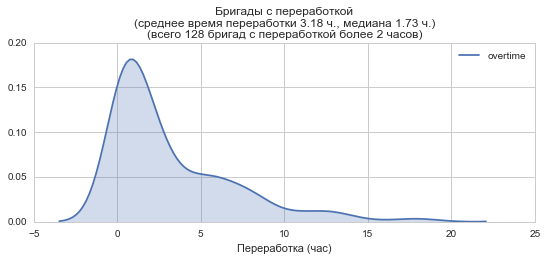

In [735]:
fig = plt.figure(figsize=(8, 3))
sns.set(style='whitegrid', context='notebook')
to_hist = team_trips.loc[team_trips.overtime > 0].overtime
sns.kdeplot(to_hist, shade=True)
title = '''Бригады с переработкой
(среднее время переработки %.2f ч., медиана %.2f ч.)
(всего %d бригад с переработкой более 2 часов)''' % \
            (to_hist.mean(), to_hist.median(), len(team_trips.loc[team_trips.overtime > 2].index))
plt.title(title)
plt.xlabel('Переработка (час)')
filename = 'team_overwork.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='leaps'></a>
## Скачки по станциям на маршруте бригад [ToC](#toc)

Проверяется, что каждый следующий участок на маршруте бригады начинается на той же станции, на которой закончился предыдущий.

**TODO**: учесть узловые станции. В системе есть понятие "узловых станций" - это несколько станций, объединенных в один узел. Узлы передаются в планировщик сообщениями `+linked_station`. Считается, что если бригада завершила работу на одной из станций узла, то она может без поезда или пассажирской нитки переместиться на другую станцию узла (считается, что эти станции находятся в плюс-минус пешей доступности). Поэтому запускать данный тест "в лоб" будет ошибкой.

In [736]:
add_header('Скачки по станциям на маршруте бригад', h=2, p=False)

### Скачки внутри планируемого маршрута бригад

In [737]:
pd.set_option('display.max_colwidth', 20)
team_cols = ['team', 'st_from_name', 'st_to_name', 'next_st', 'time_start_f', 'time_end_f', 'state', 'state_info']
team_plan['is_end'] = team_plan.team != team_plan.team.shift(-1)
team_plan['next_st'] = team_plan.st_from_name.shift(-1)
team_leaps = team_plan.loc[(team_plan.is_end == False) 
                           & (team_plan.st_to_name != team_plan.next_st)
                           & (team_plan.st_to_name.notnull())
                           & (team_plan.next_st.notnull()), team_cols]
team_leaps_n = len(team_leaps.team.drop_duplicates().index)
add_header('\nВсего бригад, у которых есть скачки на маршруте: %d' % team_leaps_n)
add_header('Всего скачков на маршруте бригад: %d (показаны первые 10):' % len(team_leaps.index))
add_line(team_leaps.head(20))

add_header('\nСтанции, на которых наблюдаются скачки (первые 5):')
add_line(team_leaps.st_to_name.value_counts().head())

# Пример маршрута такой бригады (подставить id из предыдущего вывода):
team_cols2 = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'state_info']
#team_id = '200200164017'
if not team_leaps.empty:
    team_id = team_leaps.iloc[0].team
    add_header('\nМаршрут бригады %s:' % team_id)
    add_line(team_plan.loc[team_plan.team == team_id, team_cols2])


Всего бригад, у которых есть скачки на маршруте: 1127
Всего скачков на маршруте бригад: 1184 (показаны первые 10):
         team         st_from_name           st_to_name              next_st   time_start_f     time_end_f  state state_info
 200200105777  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...            ЧЕРЕМХОВО  Aug 16, 11:20  Aug 16, 13:14      2          1
 200200105777               КУЙТУН                 АЗЕЙ                ТУЛУН  Aug 16, 23:47  Aug 17, 00:49      1          1
 200200164073  КРАСНОЯРСК-ВОСТО...  КРАСНОЯРСК-ВОСТО...                  УЯР  Aug 16, 15:05  Aug 16, 16:01      2          1
 200200225263          НОВЫЙ УРГАЛ          НОВЫЙ УРГАЛ               СОЛОНИ  Aug 16, 15:25  Aug 16, 17:25      2          1
 200200259711               ЮКТАЛИ               ЮКТАЛИ                ЛОПЧА  Aug 16, 11:48  Aug 16, 15:37      2          1
 200200225278          НОВЫЙ УРГАЛ          НОВЫЙ УРГАЛ             ЧЕГДОМЫН  Aug 16, 13:00  Aug 16, 15:00      2          1
 20020025

### Скачки между станцией исходного местоположения и первой станцией планирования

In [738]:
team_info.loc[team_info.st_from != '-1', 'first_station'] = team_info.loc[team_info.st_from != '-1', 'st_from']
team_info.loc[team_info.st_from == '-1', 'first_station'] = team_info.loc[team_info.st_from == '-1', 'oper_location']
team_info.loc[team_info.st_to != '-1', 'next_station'] = team_info.loc[team_info.st_to != '-1', 'st_to']
team_info[['team', 'oper_location', 'st_from', 'first_station', 'next_station']]
team_plan['first_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').first_station)
team_plan['next_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').next_station)
team_plan['first_st_name'] = team_plan.first_station.map(st_names.name)
team_plan['next_st_name'] = team_plan.next_station.map(st_names.name)
team_starts = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').copy(deep=True)
start_leaps = team_starts[((team_starts.first_station.isnull() == False) & (team_starts.st_from != team_starts.first_station)) | 
            ((team_starts.next_station.isnull() == False) & (team_starts.st_to != team_starts.next_station))]

In [739]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info']
first_st_leaps = team_starts[(team_starts.first_station.isnull() == False) & (team_starts.next_station.isnull())
                             & (team_starts.st_from != team_starts.first_station)]
add_header('Распределение скачков бригад по станциям местоположения (показаны первые 5):')
add_line(first_st_leaps.first_st_name.value_counts().head())
add_header('\nБригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):')
add_line(first_st_leaps[cols].head(10))

Распределение скачков бригад по станциям местоположения (показаны первые 5):
БЕЛОГОРСК                50
ХАБАРОВСК I              10
УССУРИЙСК                 5
КРАСНОЯРСК-ВОСТОЧНЫЙ      5
ИРКУТСК-СОРТИРОВОЧНЫЙ     5

Бригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):
         team         st_from_name      st_to_name          loco        first_st_name next_st_name     loco_info
 200200225165         БЕЛОГОРСК II       БЕЛОГОРСК  200200096320            БЕЛОГОРСК          NaN            -1
 200200225137  ИРКУТСК-СОРТИРОВ...      БАТАРЕЙНАЯ  200200056525  ИРКУТСК-ПАССАЖИР...          NaN  200200096452
 200200151725         БЕЛОГОРСК II         ЗАВИТАЯ  200200106714            БЕЛОГОРСК          NaN            -1
 200200105527              УГЛОВАЯ  АМУРСКИЙ ЗАЛИВ  200200075849  АРТЕМ-ПРИМОРСКИЙ...          NaN  200200075849
 200200198757         БЕЛОГОРСК II       БЕЛОГОРСК  200200079907            БЕЛОГОРСК          NaN            -1
 20

In [740]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info', 'train']
loco_info['train_number'] = loco_info.train.map(train_info.drop_duplicates('train').set_index('train').number)
team_starts['train'] = team_starts.loco_info.map(loco_info.drop_duplicates('loco').set_index('loco').train_number)
next_st_leaps = team_starts[(team_starts.next_station.isnull() == False) 
                            & (team_starts.st_to != team_starts.next_station)]
add_header('Распределение скачков бригад по станциям направления (показаны первые 5):')
add_line(next_st_leaps.next_st_name.value_counts())
add_header('\nБригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):')
add_line(next_st_leaps[cols].head(10))

Распределение скачков бригад по станциям направления (показаны первые 5):
Series([], )

Бригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):
Empty DataFrame
Columns: [team, st_from_name, st_to_name, loco, first_st_name, next_st_name, loco_info, train]
Index: []


<a id='rest_time'></a>
## Проверка времен отдыха бригад [ToC](#toc)

Проверяются две вещи:

1. Время отдыха бригад не меньше минимально допустимого времени отдыха в 3 часа.
2. Время отдыха бригад не превышает максимально допустимое: максимально бригада может отдыхать столько же, сколько работала в последней поездке до этого (от времени явки до времени ухода на отдых).

Предварительно делается отсев бригад, для которых было передано слишком раннее время последней явки - для таких бригад последнее рабочее время будет очень большим - и отдых, следовательно, тоже.

In [741]:
add_header('Проверка времен отдыха бригад', h=2, p=False)

In [742]:
add_line('Время начала планирования: %s' % nice_time(current_time))
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state', 'loco']
team_plan['time'] = np.round(((team_plan.time_end - team_plan.time_start) / 3600), 2)
rest_outliers = team_plan[(team_plan.state == 4) & (team_plan.time > 1000)]
add_header('Бригад с аномально большим временем отдыха: %d (показаны первые 10):' % len(rest_outliers.index))
out_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state']
if not rest_outliers.empty:
    add_line(rest_outliers[out_cols].head(10))

rest_check = team_plan[(team_plan.state == 4) & (team_plan.time < 1000)]

min_rest = rest_check.time.min()
if min_rest < 3:
    add_header('Минимальное время отдыха (3 часа) нарушено у %d бригад (показаны первые 10):' \
          % len(rest_check[rest_check.time < 3].index))
    add_line(rest_check[rest_check.time < 3][out_cols].head(10))    
else:
    add_header('Минимальное время отдыха бригад: %.2f часа' % (min_rest))

Время начала планирования: Aug 16, 19:31
Бригад с аномально большим временем отдыха: 0 (показаны первые 10):
Минимальное время отдыха (3 часа) нарушено у 4 бригад (показаны первые 10):
         team st_from_name st_to_name   time_start_f     time_end_f  time  state
 200200189022     МАРИИНСК   МАРИИНСК  Aug 16, 18:20  Aug 16, 19:31  1.19      4
 200200120253     МАРИИНСК   МАРИИНСК  Aug 16, 18:22  Aug 16, 19:31  1.16      4
 200200137171     МАРИИНСК   МАРИИНСК  Aug 16, 18:26  Aug 16, 19:31  1.09      4
 200200150885     МАРИИНСК   МАРИИНСК  Aug 16, 18:25  Aug 16, 19:31  1.11      4


#### Отсев бригад со слишком ранним временем явки

In [743]:
rest_old_presence = rest_check[(rest_check.info_presence < current_time - 12 * 3600) & (rest_check.state_info != '3')]
add_header('Всего %d бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:' 
           % rest_old_presence.team.count())
add_line(rest_old_presence.sort_values('time', ascending=False)[out_cols].head(10))

Всего 523 бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:
         team st_from_name   st_to_name   time_start_f     time_end_f   time  state
 200200255297       РУЖИНО       РУЖИНО  Aug 16, 07:30  Aug 17, 17:25  33.92      4
 200200157562       РУЖИНО       РУЖИНО  Aug 16, 07:40  Aug 17, 17:25  33.75      4
 200200170991     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 05:00  Aug 17, 14:44  33.73      4
 200200245840  СМОЛЯНИНОВО  СМОЛЯНИНОВО  Aug 16, 04:59  Aug 17, 14:34  33.58      4
 200200134400     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 07:30  Aug 17, 14:44  31.23      4
 200200101112     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 07:41  Aug 17, 14:44  31.05      4
 200200269806     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 09:00  Aug 17, 14:44  29.73      4
 200200134355     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 10:57  Aug 17, 14:44  27.78      4
 200200258371  ИЗВЕСТКОВАЯ  ИЗВЕСТКОВАЯ  Aug 16, 11:59  Aug 17, 14:57  26.97      4
 200200142712     САЯНСКАЯ     САЯНСКАЯ  Aug 16, 12:5

#### Бригады со слишком большим отдыхом

In [744]:
long_rest = rest_check[(rest_check.time > 10) & (rest_check.team.isin(rest_old_presence.team) == False)]
add_header('Всего %d бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):' % len(long_rest.index))
add_line(long_rest.sort_values('time', ascending=False)[out_cols].head(10))

Всего 89 бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):
         team         st_from_name           st_to_name   time_start_f     time_end_f   time  state
 200200139189               РУЖИНО               РУЖИНО  Aug 16, 18:10  Aug 17, 17:25  23.25      4
 200200137364               ЮКТАЛИ               ЮКТАЛИ  Aug 16, 17:24  Aug 17, 15:35  22.18      4
 200200143194                УРУША                УРУША  Aug 16, 13:35  Aug 17, 10:41  21.10      4
 200200250585          ИЗВЕСТКОВАЯ          ИЗВЕСТКОВАЯ  Aug 16, 17:53  Aug 17, 14:57  21.07      4
 200200087522            ОЛОВЯННАЯ            ОЛОВЯННАЯ  Aug 16, 16:10  Aug 17, 12:58  20.80      4
 200200248092             ГВОЗДЕВО             ГВОЗДЕВО  Aug 16, 17:30  Aug 17, 13:03  19.55      4
 200200269056          ВЕРХНЕЗЕЙСК          ВЕРХНЕЗЕЙСК  Aug 17, 06:11  Aug 18, 01:19  19.14      4
 200252276084          ВЕРХНЕЗЕЙСК          ВЕРХНЕЗЕЙСК  Aug 17, 06:19  Aug 18, 01:19  19.00      4
 200200254912  ЧЕР

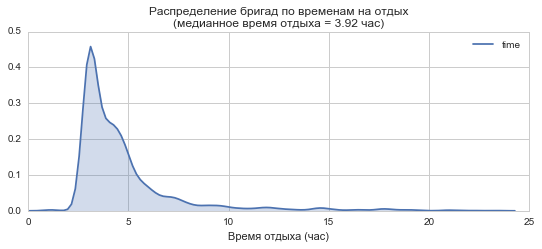

In [745]:
rest_show = rest_check[(rest_check.team.isin(rest_old_presence.team) == False)]
fig = plt.figure(figsize=(8, 3))
title = 'Распределение бригад по временам на отдых\n(медианное время отдыха = %.2f час)' % (rest_show.time.median())
sns.kdeplot(rest_show.time, shade=True)
plt.title(title)
plt.xlabel('Время отдыха (час)')
filename = 'team_rest_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Бригады с недостаточным отдыхом

In [746]:
rest = team_plan[team_plan.state == 4][['team', 'time_start', 'time']]
team_trips['rest_start_time'] = team_trips.team.map(rest.set_index('team').time_start)
team_trips['rest_start_time_f'] = team_trips.rest_start_time.apply(nice_time)
team_trips['rest_time'] = team_trips.team.map(rest.set_index('team').time)
team_trips['min_rest_time'] = np.round((team_trips.rest_start_time - team_trips.curr_presence) / (2 * 3600), 2)
team_trips['underrest'] = team_trips.min_rest_time - team_trips.rest_time

In [747]:
# Для подсчета требуемого отдыха удаляем поездки, которые связаны с одной явкой бригады; 
# для каждой явки оставляем только последнюю поездку, чтобы правильно взять полное рабочее время.
team_trips_cut = team_trips.sort_values(['team', 'curr_presence', 'work_time'], ascending=[True, True, False])\
                            .drop_duplicates(subset=['team', 'curr_presence'])

In [748]:
cols = ['team', 'curr_presence_norm', 'time_start_f', 'rest_start_time_f', 
        'work_time', 'min_rest_time', 'rest_time', 'underrest']
underrest = team_trips_cut[(team_trips_cut.time_start < team_trips_cut.rest_start_time) & (team_trips_cut.underrest > 0)]
underrest_n = underrest.team.drop_duplicates().count()
add_header('Всего %d бригад с недостаточным отдыхом:' % underrest_n)
add_header('Распределение по типу бригад:')
add_line(underrest.team_type.value_counts())

Всего 960 бригад с недостаточным отдыхом:
Распределение по типу бригад:
Реальная    711
Фейковая    249


Всего 855 бригад без переработки с недостаточным отдыхом.

Распределение по типу бригад:
Реальная    613
Фейковая    242

Примеры бригад без переработки с недостаточным отдыхом:
         team curr_presence_norm   time_start_f rest_start_time_f  work_time  min_rest_time  rest_time  underrest
 200200153030      Aug 16, 15:00  Aug 16, 22:38     Aug 17, 09:08       8.08           9.07       5.00       4.07
 200200238930      Aug 16, 13:23  Aug 16, 22:25     Aug 17, 00:40      10.80           5.65       3.00       2.65
 200200276803      Aug 16, 14:00  Aug 17, 00:30     Aug 17, 01:18      10.80           5.65       3.00       2.65
 200200093729      Aug 16, 13:00  Aug 16, 21:18     Aug 16, 23:51      10.35           5.43       3.00       2.43
 200200224052      Aug 16, 15:30  Aug 16, 19:50     Aug 17, 02:58      10.98           5.74       3.32       2.42
 200200279088      Aug 16, 12:45  Aug 16, 19:35     Aug 16, 23:12       9.95           5.23       3.00       2.23
 220205451355      Aug 1

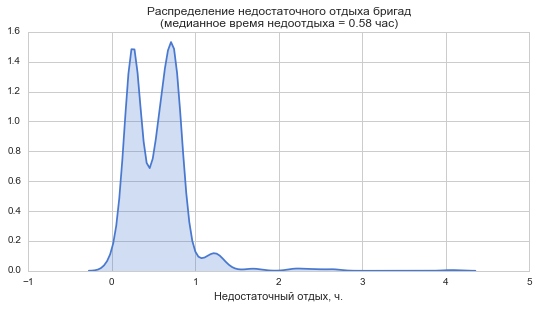

In [749]:
underrest_no_overtime = underrest[underrest.work_time <= WORK_TIME_LIMIT]
underrest_no_n = underrest_no_overtime.team.drop_duplicates().count()
add_header('Всего %d бригад без переработки с недостаточным отдыхом.' % underrest_no_n)
add_header('\nРаспределение по типу бригад:')
add_line(underrest_no_overtime.team_type.value_counts())
add_header('\nПримеры бригад без переработки с недостаточным отдыхом:')
add_line(underrest_no_overtime.sort_values('underrest', ascending=False)\
         .head(10 if underrest_no_n > 20 else underrest_no_n)[cols])

sns.set(style='whitegrid', context='notebook')
title = 'Распределение недостаточного отдыха бригад\n(медианное время недоотдыха = %.2f час)' \
            % (underrest_no_overtime.underrest.median())
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(underrest_no_overtime.underrest, color='b', hist=False, kde_kws={'shade':True})
ax.set(title=title, xlabel='Недостаточный отдых, ч.')
filename = 'team_under_rest.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [750]:
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['train'] = team_plan.loco_time.map(loco_plan.drop_duplicates('loco_time').set_index('loco_time').train)
#print(team_plan[team_plan.team == '777700000270']\
#      [['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 
#        'state', 'loco', 'train', 'time']].to_string(index=False))
time.ctime(1463065200)

'Thu May 12 18:00:00 2016'

## Проверка подвязки бригад по Иркутску

Отдельно для станции Иркутск считается, сколько всего поездов проезжало через Иркутск и сколько бригад было отправлено из Иркутска (в том числе, пассажирами). Для бригад выдается распределение бригад по депо приписки.

In [751]:
add_header('Анализ бригад, проезжающих через Иркутск', h=2, p=False)

In [752]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'depot_name']
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
train_cols = ['train', 'number', 'st_from_name', 'st_to_name', 'time_start_f']
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
add_header('Распределение поездов через Иркутск по направлениям:')
add_line(train_plan.loc[(train_plan.st_from_name == st_name)
              & (train_plan.time_start >= current_time) & (train_plan.train_type.isin(['2', '9']))
              & (train_plan.time_start < current_time + 24*3600), train_cols].st_to_name.value_counts())

add_header('\nРаспределение бригад, в маршруте которых есть Иркутск, по депо приписки:')
b = team_plan.loc[(team_plan.st_from_name == st_name) & (team_plan.state.isin([0, 1]))
              & (team_plan.time_start >= current_time), team_cols].groupby('depot_name').team.count().to_frame()
b['percent'] = np.round((100 * b.team / b.team.sum()), 2)
b['percent'] = b['percent'].apply(lambda x: str(x) + '%')
add_line(b.reset_index())

Распределение поездов через Иркутск по направлениям:
ГОНЧАРОВО     48
БАТАРЕЙНАЯ    33

Распределение бригад, в маршруте которых есть Иркутск, по депо приписки:
          depot_name  team percent
                ЗИМА    71  47.02%
 ИРКУТСК-СОРТИРОВ...    68  45.03%
          СЛЮДЯНКА I     6   3.97%
            УЛАН-УДЭ     5   3.31%
               ХИЛОК     1   0.66%


<a id='ready_time'></a>
## Проверка времени явки бригад [ToC](#toc)

In [753]:
add_header('Проверка корректости времен явки бригад в депо приписки во входных данных', h=2, p=False)

1. У бригад, которые находятся на домашнем отдыхе (state = 3) передается именно время ухода на отдых. По постановке (см. раздел "Заполнение атрибутов для входных сообщений по бригадам") должно передаваться время ухода на отдых + 16 часов.
2. Для бригады 200200158216 передается state=3, хотя по АСУ-Т последней операцией на 18.04 10:35 было "прибытие на станцию Лесовозный 17.04 в 08:49" (или, в крайнем случае, отправление с Улан-Удэ 17.04 в 07:51).
3. Аналогично для бригады 200200225600. Впрочем, возможно, это какой-то косяк АСУ-Т. В любом случае, пункт 1 - это очевидный баг.

Общая идея:
- если у бригад указано depot_time < rest_start_time, то эта разница не должна быть очень большой. 
- если у бригад указано depot_time < return_time, то эта разница тоже не должна быть очень большой.

In [754]:
add_line('Время начала планирования: %s' % (nice_time(current_time)))
team_info['dt_norm'] = team_info.depot_time.apply(nice_time)
team_info['rt_norm'] = team_info.return_time.apply(nice_time)
team_info['rst_norm'] = team_info.rest_time.apply(nice_time)
team_info['rest_dep_delta'] = np.round(((team_info.rest_time - team_info.depot_time) / 3600), 2)
team_info['return_dep_delta'] = np.round(((team_info.return_time - team_info.depot_time) / 3600), 2)

dep_less_rest = team_info[(team_info.depot_time < team_info.rest_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'rest_dep_delta', 'ready_type', 'state']
add_header('Всего %d бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:' 
          % dep_less_rest[dep_less_rest.rest_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_rest[dep_less_rest.rest_dep_delta > 12][info_cols].sort_values('rest_dep_delta', ascending=False).head(10))

dep_less_return = team_info[(team_info.depot_time < team_info.return_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'return_dep_delta', 'ready_type', 'state']
add_header('\nВсего %d бригад, у которых время последней явки в депо намного меньше (на 18+ часов) времени явки в пункте оборота. Примеры:' 
          % dep_less_return[dep_less_return.return_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_return[dep_less_return.return_dep_delta > 12][info_cols].sort_values('return_dep_delta', ascending=False).head(10))

Время начала планирования: Aug 16, 19:31
Всего 385 бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:
         team      number dt_norm       rst_norm  rest_dep_delta ready_type state
 200200260904  9606000082          Aug 16, 13:00       408706.00     return     4
 200200213758  8805006079          Aug 16, 12:40       408705.67     return     4
 200200114697  8877007011          Aug 16, 10:44       408703.73     return     1
 200200112872  9406022808          Aug 16, 05:51       408698.85     return     0
 200254430379  9601013221          Aug 16, 05:09       408698.15     return     1
 200200128825  9406026795          Aug 15, 23:00       408692.00     return     0
 200200169293  9406022294          Aug 15, 22:50       408691.83     return     0
 200200132361  9406020198          Aug 15, 22:14       408691.23     return     0
 200200251648  9406000905          Aug 15, 21:25       408690.42     return     0
 20020018

<a id='change'></a>
## Проверка смены бригад на корректных станциях [ToC](#toc)

Тест работает в двух направлениях:
1. Проверяется отсутствие смены бригад на станциях, где бригады обязательно должны меняться.
2. Проверяется, что бригады вообще меняются только на станциях, где это разрешено делать. Допустимые станции перечислены в файле `mandatory/priority_team_change_stations.csv`.

In [755]:
add_header('Проверка смены бригад на корректных станциях', h=2, p=False)

### Проверка случаев проезда бригад мимо станций обязательной смены

In [756]:
add_header('Проверка проезда бригад мимо станций обязательной смены', h=3, p=False)

In [757]:
st_team_change_full = ['КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗИМА', 'ХИЛОК', 'МОГОЧА', 'ОБЛУЧЬЕ', 'РУЖИНО', 'СМОЛЯНИНОВО', 
                      'САЯНСКАЯ', 'ЛЕНА', 'СЕВЕРОБАЙКАЛЬСК', 'НОВЫЙ УОЯН', 
                      'НОВАЯ ЧАРА', 'ЮКТАЛИ', 'ВЕРХНЕЗЕЙСК', 'ФЕВРАЛЬСК', 'ПОСТЫШЕВО', 'ВЫСОКОГОРНАЯ', 
                      'УЖУР', 'ТЫРМА']
                 
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'loco_end', 'no_stop']
team_plan['loco_end'] = team_plan.loco != team_plan.loco.shift(-1)
team_plan['no_stop'] = team_plan.time_end == team_plan.time_start.shift(-1)
no_stop = team_plan[(team_plan.st_to_name.isin(st_team_change_full)) & (team_plan.state == 1) 
                    & (team_plan.loco_end == False) & (team_plan.no_stop == True)]
add_header('Всего %d случаев проезда бригад мимо станций обязательной смены' % len(no_stop.index))
add_header('\nРаспределение по станциям (первые 5 самых частых):')
add_line(no_stop.st_to_name.value_counts().head())

Всего 55 случаев проезда бригад мимо станций обязательной смены

Распределение по станциям (первые 5 самых частых):
ЗИМА           26
ОБЛУЧЬЕ        11
РУЖИНО          5
НОВЫЙ УОЯН      5
СМОЛЯНИНОВО     3


In [758]:
add_header('\nПримеры ошибочных бригад (первые 10):')
add_line(no_stop.drop_duplicates('st_to_name').sort_values('time_end')[cols])


Примеры ошибочных бригад (первые 10):
         team     st_from_name   st_to_name   time_start_f     time_end_f  state          loco loco_end no_stop
 200200120385          ШКОТОВО  СМОЛЯНИНОВО  Aug 16, 19:12  Aug 16, 19:34      1  200200101122    False    True
 200200126652           АРХАРА      ОБЛУЧЬЕ  Aug 16, 21:10  Aug 16, 23:26      1  200200092733    False    True
 200200281233         ЖИПХЕГЕН        ХИЛОК  Aug 16, 23:49  Aug 17, 00:22      1  200200084026    False    True
 777700001880  СЕВЕРОБАЙКАЛЬСК   НОВЫЙ УОЯН  Aug 17, 08:05  Aug 17, 11:13      1  200200105728    False    True
 200200129791         ТАЛАНДЖА        ТЫРМА  Aug 17, 10:18  Aug 17, 12:11      1  200200054696    False    True
 777700002207          ПЕРЕВОЗ         ЗИМА  Aug 17, 15:46  Aug 17, 16:02      1  200200079530    False    True
 777700002168         ШМАКОВКА       РУЖИНО  Aug 17, 18:37  Aug 17, 19:23      1  200200039667    False    True
 777700002444    КРАСНАЯ СОПКА         УЖУР  Aug 17, 18:20  Aug 1

In [759]:
add_header('Полные планы по некоторым ошибочным бригадам:')
num_fail_stations = len(no_stop.st_to_name.value_counts())
lim = 2 if num_fail_stations > 1 else num_fail_stations
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
for i in range(lim):
    st = no_stop.st_to_name.value_counts().index[i]
    add_line(team_plan[team_plan.team == no_stop[no_stop.st_to_name == st].iloc[0].team][cols])
    add_line('')

Полные планы по некоторым ошибочным бригадам:
         team         st_from_name           st_to_name   time_start_f     time_end_f  state          loco
 777700002207          НИЖНЕУДИНСК               УДА II  Aug 17, 11:20  Aug 17, 11:35      1  200200079530
 777700002207               УДА II                ТУЛУН  Aug 17, 11:35  Aug 17, 13:26      1  200200079530
 777700002207                ТУЛУН                 АЗЕЙ  Aug 17, 13:26  Aug 17, 13:52      1  200200079530
 777700002207                 АЗЕЙ               КУЙТУН  Aug 17, 13:52  Aug 17, 14:54      1  200200079530
 777700002207               КУЙТУН              ПЕРЕВОЗ  Aug 17, 14:54  Aug 17, 15:46      1  200200079530
 777700002207              ПЕРЕВОЗ                 ЗИМА  Aug 17, 15:46  Aug 17, 16:02      1  200200079530
 777700002207                 ЗИМА               ЗАЛАРИ  Aug 17, 16:02  Aug 17, 17:08      1  200200079530
 777700002207               ЗАЛАРИ            ЧЕРЕМХОВО  Aug 17, 17:08  Aug 17, 18:23      1  2002

#### Причины проезда бригад мимо станций смены:

1. Новый Уоян: у бригад в участках обкатки присутствует участок 2002118258 (Северобайкальск -- Таксимо). Возможное решение: проверить участки обкатки, выяснить, откуда берется участок обкатки Северобайкальск -- Таксимо, удалить этот участок при необходимости.

2. Зима. Фейковым бригадам хватает рабочего времени, чтобы доехать из Иркутска до Нижнеудинска (время хода --- чуть более 9 часов). Для этих бригад должен определяться УОЛБ 920502 "Иркутск -- Зима" с нормативным рабочим временем ровно 9 часов (540). Так что должна планироваться смена в Зиме. Возможные причины ошибки:
  1. Определяется другой УОЛБ - а именно, УОЛБ 920503 "Иркутск -- Гончарово, Кая -- Зима". У этого УОЛБ рабочее время = 600 (10 часов). 
  2. У фейковой бригады неверно указывается депо приписки (или не указывается вообще). Тогда для нее может вообще не быть найден УОЛБ.

### Проверка случаев смены бригад не на допустимых станциях

In [760]:
add_header('Проверка случаев смены бригад не на допустимых станциях', h=3, p=False)

In [761]:
add_line('Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда' + 
         ', а также случаи смены бригады на станции, которая является депо приписки бригады')

Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда, а также случаи смены бригады на станции, которая является депо приписки бригады


In [762]:
loco_plan['end_trip'] = (loco_plan.state != loco_plan.state.shift(-1)) | (loco_plan.train != loco_plan.train.shift(-1))\
                        | (loco_plan.loco != loco_plan.loco.shift(-1))
team_plan['start_station_name'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                     .drop_duplicates('team').set_index('team').st_from_name)
team_plan.depot_name.fillna(team_plan.start_station_name, inplace=True)
team_plan['depot_st_name'] = team_plan.depot_st.map(st_names.name)
team_plan.depot_st_name.fillna(team_plan.start_station_name, inplace=True)
loco_plan['team_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_name)
loco_plan['team_ready_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_st_name)

In [763]:
pr_st = pd.read_csv(FOLDER + 'mandatory/priority_team_change_stations.csv', sep=';', 
                    encoding='utf-8-sig', dtype={'station':str}).station
loco_plan['team_end'] = loco_plan.team != loco_plan.team.shift(-1)
team_change = loco_plan[(loco_plan.state != 4) & (loco_plan.team_end == True) & (loco_plan.end_trip == False)]
bad_team_change = team_change[(team_change.st_to.isin(pr_st) == False) 
                              & (team_change.st_to_name != team_change.team_depot_name)
                              & (team_change.st_to_name != team_change.team_ready_depot_name)]
if bad_team_change.st_to_name.dropna().empty:
    add_header('Все бригады меняются только на приоритетных станциях смены')
else:
    add_header('Всего %d случаев смены бригад не на приоритетных станциях смены (%.2f%%)'
              % (bad_team_change.loco.count(), 100 * bad_team_change.loco.count() / team_change.loco.count()))
    add_header('Распределение по неприоритетным станциям (первые 10):')
    add_line(bad_team_change.st_to_name.value_counts().head(10))   
    

Всего 13 случаев смены бригад не на приоритетных станциях смены (0.52%)
Распределение по неприоритетным станциям (первые 10):
УЯР                     10
КОМСОМОЛЬСК-НА-АМУРЕ     2
БАЗАИХА                  1


In [764]:
with (pd.option_context('display.max_colwidth', 20)):
    if not bad_team_change.st_to_name.dropna().empty:
        add_header('Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:')
        add_line(bad_team_change[['loco', 'team', 'st_to_name', 'time_end_f', 'train']].head(10))
        cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'train', 'team', 'team_depot_name']        
        loco_id = bad_team_change[bad_team_change.st_to_name == bad_team_change.st_to_name.value_counts().idxmax()]\
                    .drop_duplicates('loco').iloc[0,:].loco
        add_header('Полный план по одному из таких локомотивов:')
        add_line(loco_plan[loco_plan.loco == loco_id][cols])

Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:
         loco          team           st_to_name     time_end_f            train
 200200097256  200200136519  КОМСОМОЛЬСК-НА-А...  Aug 17, 13:33     200252963140
 200200085774  777700002303              БАЗАИХА  Aug 17, 13:39     200254704833
 200200046643  200200069697  КОМСОМОЛЬСК-НА-А...  Aug 17, 07:28     200254479600
 200200080956  777700001826                  УЯР  Aug 17, 02:46  999928799032001
 200200073476  777700002033                  УЯР  Aug 17, 05:56  999928799032007
 200200075320  777700002026                  УЯР  Aug 17, 09:19     200252226730
 200200086862  777700002025                  УЯР  Aug 17, 11:35     200252516713
 200200092705  777700001824                  УЯР  Aug 17, 01:51   88880010124231
 200200104594  777700002252                  УЯР  Aug 17, 21:58   88880010874843
 200200049915  777700002020                  УЯР  Aug 17, 15:39     200253445618
Полны

<a id='presence'></a>
## Проверка отправления бригады не ранее времени явки [ToC](#toc)

In [765]:
add_header('Проверка отправления бригады не ранее времени явки', h=2, p=False)

In [766]:
# Вычисляем максимальное время явки, добавляем его в team_info и team_plan
# В таблице presence_fail --- ошибочные отправления бригад до времени явки

presence_lim = 0
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'ready_type', 
             'presence_norm', 'presence_gap', 'state', 'state_info']

team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: x[0] if x[0] > x[1] else x[1])
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['presence_norm'] = team_plan.presence.apply(nice_time)
team_plan['presence_gap'] = team_plan.time_start - team_plan.presence
team_plan['ready_type'] = team_plan.team.map(team_info.set_index('team').ready_type)
presence_fail = team_plan[(team_plan.state.isin([0, 1])) & (team_plan.presence_gap < presence_lim)].drop_duplicates('team')
pr = team_info[['team', 'depot_time', 'return_time', 'presence', 'presence_norm']]

In [767]:
p = presence_fail[presence_fail.state == 0]
ph = presence_fail[(presence_fail.state == 0) & (presence_fail.time_start >= current_time)]
if not p.empty:
    add_header('Всего бригад, которые отправлены пассажиром ранее времени явки: %d (показаны первые 10)' % p.team.count())
    add_line(p.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки')
    
if not ph.empty:
    add_header('\nВсего бригад, которые отправлены пассажиром ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % ph.team.count())
    add_line(ph.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования')

Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки

Нет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования


In [768]:
f = presence_fail[presence_fail.state == 1]
fh = presence_fail[(presence_fail.state == 1) & (presence_fail.time_start >= current_time)]
if not f.empty:
    add_header('Всего бригад, которые отправлены с локомотивом ранее времени явки: %d (показаны первые 10)' % f.team.count())
    add_line(f.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки')

if not fh.team.empty:
    add_header('\nВсего бригад, которые отправлены с локомотивом ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % fh.team.count())
    add_line(fh.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования')

Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки

Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования


<a id='before_current_time'></a>
## Проверка планирования бригад до времени начала планирования [ToC](#toc)

In [769]:
add_header('Проверка планирования бригад до времени начала планирования', h=2, p=False)

In [770]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'state_info']

add_line('(Не учитываются бригады, которые на начало планирования находились на перегоне)')
add_line('Время начала планирования: %s' % nice_time(current_time))

total_teams = team_plan.team.drop_duplicates().count()

tbef = team_plan[(team_plan.time_start < current_time)          
         & (team_plan.state.isin([0, 1])) & (team_plan.state_info != team_plan.state.apply(str))].drop_duplicates('team')
add_header('\nВсего бригад, отправленных до начала планирования: %d (%.2f%% от всех запланированных бригад)' 
           % (tbef.team.count(), 100 * tbef.team.count() / total_teams))
if not tbef.empty:
    add_header('\nРаспределение по состояниям бригад, отправленных до начала планирования:')
    add_line(tbef.state.value_counts())
    
    for i in sorted(tbef.state.unique()):
        add_header('\nБригады, отправленные до начала планирования в состоянии %d (первые 10):' % i)
        add_line(tbef[tbef.state == i].sort_values('time_start').head(10)[team_cols])

    add_header('\nРаспределение по типу бригад, отправленных до начала планирования в состоянии 1:')
    add_line(tbef[tbef.state == 1].team_type.value_counts())

(Не учитываются бригады, которые на начало планирования находились на перегоне)
Время начала планирования: Aug 16, 19:31

Всего бригад, отправленных до начала планирования: 0 (0.00% от всех запланированных бригад)


<a id='presenting'></a>
## Проверка планируемых явок бригад [ToC](#toc)

In [771]:
add_header('Проверка планируемых явок бригад', h=2, p=False)

Разброс времен на явку бригад: от 0.32 ч. до 5.90 ч.


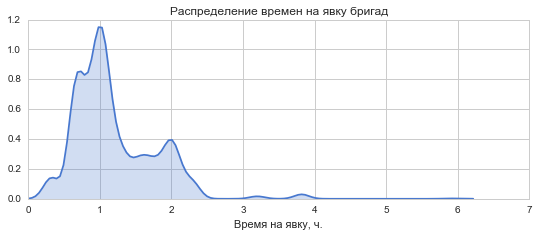

In [772]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'tt', 'state', 'loco', 'state_info']
team_plan['tt'] = team_plan.time_end - team_plan.time_start
min_presenting = team_plan[team_plan.state == 2][team_cols].tt.min()
max_presenting = team_plan[team_plan.state == 2][team_cols].tt.max()
add_header('Разброс времен на явку бригад: от %.2f ч. до %.2f ч.' % (min_presenting / 3600, max_presenting / 3600))

sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 3))
ax = sns.distplot(team_plan[team_plan.state == 2][team_cols].tt / 3600, hist=False, bins=20, color='b', kde_kws={'shade':True})
ax.set(xlabel='Время на явку, ч.', title='Распределение времен на явку бригад')
filename = 'team_presenting.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [773]:
team_plan['next_state'] = team_plan.state.shift(-1)
team_plan['next_time_start_f'] = team_plan.time_start_f.shift(-1)
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'next_state', 'time_start_f', 'time_end_f', 'next_time_start_f']
rest_pres = team_plan[(team_plan.team == team_plan.team.shift(-1)) 
                     & (team_plan.state == 4) & (team_plan.next_state == 2)
                     & (team_plan.time_end_f != team_plan.next_time_start_f)]
add_header('Всего %d бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):' 
      % rest_pres.team.drop_duplicates().count())
add_line(rest_pres[rest_pres.time_start >= current_time].sort_values('time_start').head(10)[cols])
add_header('\nРаспределение таких ошибочных явок после отдыха по станциям (показаны первые 5):')
add_line(rest_pres.st_from_name.value_counts().head())

Всего 1241 бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):
         team         st_from_name           st_to_name  state  next_state   time_start_f     time_end_f next_time_start_f
 200200140883  ЧЕРНЫШЕВСК-ЗАБАЙ...  ЧЕРНЫШЕВСК-ЗАБАЙ...      4           2  Aug 16, 19:32  Aug 16, 23:23     Aug 17, 00:53
 200200279971               РУЖИНО               РУЖИНО      4           2  Aug 16, 19:35  Aug 16, 22:35     Aug 17, 03:39
 200200202146            ГРОДЕКОВО            ГРОДЕКОВО      4           2  Aug 16, 19:40  Aug 16, 22:40     Aug 17, 00:49
 200200191285              ОБЛУЧЬЕ              ОБЛУЧЬЕ      4           2  Aug 16, 19:40  Aug 17, 00:50     Aug 17, 01:31
 200200118562            КАРЫМСКАЯ            КАРЫМСКАЯ      4           2  Aug 16, 19:41  Aug 16, 22:47     Aug 16, 23:04
 200200220508               МОГОЧА               МОГОЧА      4           2  Aug 16, 19:42  Aug 16, 22:42     Aug 16, 23:41
 200200261354                УРУША 

<a id='check_useful_assign'></a>
## Проверка использования бригад [ToC](#toc)

In [774]:
add_header('Проверка использования бригад', h=2, p=False)

<a id='only_pass'></a>
### Бригады, запланированные к отправлению пассажирами без последующей подвязки [ToC](#toc)

Тест проверяет, что если у бригады запланирована отправка пассажром, то либо бригада пересылается в депо приписки (и тогда у бригады больше нет других планов), либо после такой пересылки бригада ведет локомотив (то есть далее есть участок маршрута с состоянием state = 1). 

In [775]:
add_header('Проверка использования бригад после засылки пассажирами', h=3, p=False)

In [776]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'depot_name',
        'state', 'all_states']

In [777]:
def get_cat(all_states):
    if 1 in all_states:
        return 'work'
    elif (len(all_states) == 1) & (all_states[0] == 2):
        return 'only_presence'
    elif (len(all_states) == 2):
        if ((all_states[0] == 4) & (all_states[1] == 0)):
            return 'pass_home'
        else:
            return 'fail'
    elif (len(all_states) == 3):
        if all([2, 4, 0] == all_states):
            return 'pass_home'
        else:
            return 'fail'
    else:
        return 'fail'

team_plan['cat'] = team_plan.all_states.apply(get_cat)
only_pass_teams = team_plan[(team_plan.cat == 'fail') & (team_plan.state_info != '2')]
                            
add_header('Всего %d бригад, для которых планируется отправка пассажиром и не планируется работа с поездом' 
      % only_pass_teams.team.drop_duplicates().count())

Всего 12 бригад, для которых планируется отправка пассажиром и не планируется работа с поездом


In [778]:
add_header('Станции, с которых чаще всегда планируется лишняя отправка пассажирами:')
add_line(only_pass_teams.drop_duplicates('team').st_from_name.value_counts().head(10))

Станции, с которых чаще всегда планируется лишняя отправка пассажирами:
ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ              3
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ    1
АЧИНСК I                              1
НОВЫЙ УРГАЛ                           1
ТЫНДА                                 1
КРАСНОЯРСК-ВОСТОЧНЫЙ                  1


In [779]:
with pd.option_context('display.max_colwidth', 25):
    if only_pass_teams.team.drop_duplicates().count() != 0:
        add_header('Примеры:')
        for team in only_pass_teams.team.drop_duplicates().iloc[:3].values:    
            add_line(team_plan[team_plan.team == team][cols])
            add_line('')

Примеры:
         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200189022          NaN        NaN  Aug 16, 13:00  Aug 16, 14:00        NaN      2     [2, 4]
 200200189022     МАРИИНСК   МАРИИНСК  Aug 16, 18:20  Aug 16, 19:31        NaN      4     [2, 4]

         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200226077        ТЫНДА      ТЫНДА  Aug 16, 14:23  Aug 16, 20:43      ТЫНДА      4        [4]

         team              st_from_name                st_to_name   time_start_f     time_end_f            depot_name  state all_states
 200200083199  КОМСОМОЛЬСК-НА-АМУРЕ-...  КОМСОМОЛЬСК-НА-АМУРЕ-...  Aug 15, 13:00  Aug 15, 15:00  КОМСОМОЛЬСК-НА-АМУРЕ      2     [2, 4]
 200200083199  КОМСОМОЛЬСК-НА-АМУРЕ-...  КОМСОМОЛЬСК-НА-АМУРЕ-...  Aug 16, 00:26  Aug 16, 03:26  КОМСОМОЛЬСК-НА-АМУРЕ      4     [2, 4]



In [780]:
irk = only_pass_teams[only_pass_teams.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ']
if not irk.empty:
    add_header('Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:')
    add_line(team_plan[team_plan.team == irk.iloc[0].team][cols])

<a id='only_presence'></a>
### Бригады, планируемые только на явку [ToC](#toc)

Тест находит бригады, у которых в возвращаемом плане есть только один участок маршрута и на этом участке state = 2. Такие бригады не должны возвращаться (по ним не планируется ничего, кроме явки, смысла в их планировании нет).

In [781]:
add_header('Бригады, планируемые только на явку', h=3, p=False)

In [782]:
cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'depot_name', 'state_info', 'all_states']
only_pr = team_plan[team_plan.cat == 'only_presence']
if not only_pr.empty:
    add_header('Всего %d бригад, запланированных только на явку.' % only_pr.team.drop_duplicates().count())
    add_line('')
    add_header('Распределение по депо станции явки:')
    add_line(only_pr.drop_duplicates('team').st_from_name.value_counts().head())
    add_line('')
    add_header('Распределение по типу бригады:')
    add_line(only_pr.drop_duplicates('team').team_type.value_counts())
    add_line('')
    add_header('Примеры бригад:')
    add_line(only_pr[cols].head(10))
else:
    add_header('В плане нет бригад, запланированных только на явку')

Всего 533 бригад, запланированных только на явку.

Распределение по депо станции явки:
КРАСНОЯРСК-ВОСТОЧНЫЙ                  112
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ     74
УЯР                                    62
УССУРИЙСК                              25
КАРЫМСКАЯ                              20

Распределение по типу бригады:
Фейковая    356
Реальная    177

Примеры бригад:
         team         st_from_name   time_start_f     time_end_f           depot_name state_info all_states
 200200189151            УССУРИЙСК  Aug 16, 03:48  Aug 16, 05:00            УССУРИЙСК          2        [2]
 200200268458               ЧИТА I  Aug 16, 08:40  Aug 16, 10:00               ЧИТА I          2        [2]
 200200112276            ВИХОРЕВКА  Aug 16, 17:24  Aug 16, 19:11            ВИХОРЕВКА          2        [2]
 200200216221                 ЗИМА  Aug 16, 18:24  Aug 16, 19:05          НИЖНЕУДИНСК          8        [2]
 200200223934  ЧЕРНЫШЕВСК-ЗАБАЙ...  Aug 16, 04:45  Aug 16, 05:37  ЧЕРНЫШЕВСК-ЗАБАЙ

## Проверка наличия явки в планах у всех запланированных бригад

Если в плане у бригады есть езда с локомотивом (state = 1), то должен присутствовать хотя бы один участок с операцией явки (state = 2).

In [783]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
no_pres = team_plan[team_plan.all_states.apply(lambda x: (2 not in x) & (1 in x))]
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
add_header('Всего событие явки не запланировано у %d бригад (%.2f%%). Примеры:'
           % (no_pres.drop_duplicates('team').team.count(),
              100 * no_pres.drop_duplicates('team').team.count() / team_plan.drop_duplicates('team').team.count()))
add_line(team_plan[team_plan.team == no_pres.iloc[0].team][cols])
add_line(team_plan[team_plan.team == no_pres.iloc[1].team][cols])
add_header('Распределение по типу бригад (в долях):')
add_line(no_pres.drop_duplicates('team').team_type.value_counts(normalize=True))

Всего событие явки не запланировано у 176 бригад (4.07%). Примеры:
         team     st_from_name       st_to_name   time_start_f     time_end_f  state          loco
 777700002835           МОГОЧА           АМАЗАР  Aug 17, 17:00  Aug 17, 18:59      1  200200097356
 777700002835           АМАЗАР  ЕРОФЕЙ ПАВЛОВИЧ  Aug 17, 18:59  Aug 17, 21:18      1  200200097356
 777700002835  ЕРОФЕЙ ПАВЛОВИЧ            УРУША  Aug 17, 21:18  Aug 17, 23:23      1  200200097356
 777700002835            УРУША        БАМОВСКАЯ  Aug 17, 23:23  Aug 18, 00:46      1  200200097356
 777700002835        БАМОВСКАЯ          ГОРЕЛЫЙ  Aug 18, 00:46  Aug 18, 00:53      1  200200097356
 777700002835          ГОРЕЛЫЙ      СКОВОРОДИНО  Aug 18, 00:53  Aug 18, 01:32      1  200200097356
         team     st_from_name       st_to_name   time_start_f     time_end_f  state          loco
 777700002835           МОГОЧА           АМАЗАР  Aug 17, 17:00  Aug 17, 18:59      1  200200097356
 777700002835           АМАЗАР  ЕРОФЕЙ ПАВ

<a id='pass_teams_in_plan'></a>
## Проверка подвязки негрузовых бригад [ToC](#toc)

Негрузовые бригады (бригады с type = 0) не должны подвязываться на локомотивы. Исключение: если бригада на начало планирования следует с локомотивом. В этом случае в результатах по этой бригаде (если они есть) не должно присутствовать других локомотивов, кроме того, который был указан во входных данных.

In [784]:
add_header('Проверка подвязки негрузовых бригад', h=2, p=False)

In [785]:
cols = ['team', 'ttype', 'loco_info', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco']
bad_pass_teams = team_plan[(team_plan.ttype == 0) & (team_plan.loco != team_plan.loco_info) 
                           & (team_plan.state.isin([0, 1]))][cols]
if bad_pass_teams.empty:
    add_header('В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных')
else:
    add_header('Всего %d негрузовых бригад, для которых запланирована подвязка, отличная от подвязки во входных данных:' 
              % bad_pass_teams.drop_duplicates('team').team.count())
    add_line(bad_pass_teams.drop_duplicates('team')[cols].head())

В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных


[ToC](#toc)
## Проверка сохранения предыдущих времен явок

В планировщик в сообщениях `prev_team` передаются времена явок бригад, запланированные на предыдущем расчете. В зависимости от горизонта, на котором запланированы эти явки, их при новом расчете можно сдвигать лишь на очень ограниченное время.

In [786]:
add_header('Проверка сохранения предыдущих времен явок', h=2, p=False)

In [787]:
add_line('Время начала планирования: %s' % nice_time(current_time))
prev_team = pd.read_csv(FOLDER + 'prev_team.csv', dtype={'team':str})
prev_team['dt_time'] = prev_team.prev_ready_time.apply(nice_time)
prev_team['team_type'] = prev_team.team.apply(lambda x: int(str(x)[0]))
prev_team['plan_hor'] = (prev_team.prev_ready_time - current_time) / 3600
team_plan['prev_ready_time'] = team_plan.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_plan['prev_ready_time_f'] = team_plan.prev_ready_time.apply(nice_time)

prev_team_no_planned = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))
                                 & (prev_team.team.isin(team_plan[team_plan.state.isin([0, 1])].team) == False)]
prev_team_no_planned_6 = prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                              & (prev_team_no_planned.plan_hor < 6)]
prev_team_n = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))].team.count()
if prev_team_no_planned.empty:
    add_header('Все бригады с предыдущими явками запланированы')
else:
    add_header('Не запланировано %d бригад (%.2f%%) с предыдущими явками (%d на горизонте до 6 часов). Примеры:'
              % (prev_team_no_planned.team.count(),                  
                 100 * prev_team_no_planned.team.count() / prev_team_n,
                 prev_team_no_planned_6.team.count()))
    add_line(prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                  & (prev_team_no_planned.plan_hor < 6)].sort_values('plan_hor').head(10))    

cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'state', 'prev_ready_time_f']
tp_first = team_plan[team_plan.team.isin(team_info[team_info.state == '3'].team)].drop_duplicates('team').copy()
#tp_first = team_plan.drop_duplicates('team').copy()

Время начала планирования: Aug 16, 19:31
Не запланировано 320 бригад (12.39%) с предыдущими явками (37 на горизонте до 6 часов). Примеры:
         team  prev_ready_time        dt_time  team_type  plan_hor
 200200247163       1471365600  Aug 16, 19:40          2  0.143889
 200200108280       1471365645  Aug 16, 19:40          2  0.156389
 200200266558       1471365660  Aug 16, 19:41          2  0.160556
 200200114712       1471366200  Aug 16, 19:50          2  0.310556
 200200278158       1471366200  Aug 16, 19:50          2  0.310556
 200200251636       1471366500  Aug 16, 19:55          2  0.393889
 200200137338       1471366800  Aug 16, 20:00          2  0.477222
 200200252928       1471366800  Aug 16, 20:00          2  0.477222
 200200105626       1471366800  Aug 16, 20:00          2  0.477222
 200200200500       1471367400  Aug 16, 20:10          2  0.643889


In [788]:
def get_prev_ready_lag(prev_ready_time, current_time):
    if np.isnan(prev_ready_time): prev_ready_time = 0        
    d = prev_ready_time - current_time
    if d < 3 * 3600:
        lag = 0    
    elif d < 6 * 3600:
        lag = 3 * 3600
    else:
        lag = 24 * 3600
    return lag

tp_first['good_lag'] = tp_first.apply(lambda x: get_prev_ready_lag(x.prev_ready_time, current_time), axis=1)
cols = ['team', 'st_from_name', 'time_start_f', 'state', 'prev_ready_time_f', 'good_lag', 'real_lag', 
        'state_info', 'presence_norm', 'uth']
tp_first['real_lag'] = tp_first.time_start - tp_first.prev_ready_time
good_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2)
                     & (tp_first.good_lag >= np.abs(tp_first.real_lag))]

bad_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2) 
                    & (tp_first.presence <= tp_first.prev_ready_time)
                    & (tp_first.good_lag < np.abs(tp_first.real_lag))]
if bad_prev.empty:
    add_header('Все запланированные бригады с предыдущими явками запланированы на явку без неприемлемых задержек')
else:
    add_header('Всего %d бригад с предыдущими явками (%.2f%% от запланированных) с существенными отклонениями времен явок:'
              % (bad_prev.team.count(), 
                 100 * bad_prev.team.count() / (prev_team.team.count() - prev_team_no_planned.team.count())))
    add_line(bad_prev[cols].head(10))

Всего 12 бригад с предыдущими явками (0.41% от запланированных) с существенными отклонениями времен явок:
         team         st_from_name   time_start_f  state prev_ready_time_f  good_lag  real_lag state_info  presence_norm  uth
 200200277440            ПОСТЫШЕВО  Aug 16, 21:48      2     Aug 16, 19:15         0      9180          3  Aug 16, 15:40    0
 200200250074  КОМСОМОЛЬСК-НА-А...  Aug 16, 20:15      2     Aug 16, 19:05         0      4200          3  Aug 16, 17:00    0
 200200242099          ХАБАРОВСК I  Aug 16, 21:10      2     Aug 16, 21:01         0       590          3  Aug 16, 18:55    0
 200200188765             ГВОЗДЕВО  Aug 16, 19:40      2     Aug 16, 17:04         0      9406          3  Aug 16, 16:00    0
 200200265851          ХАБАРОВСК I  Aug 16, 20:24      2     Aug 16, 19:20         0      3840          3  Aug 16, 17:37    0
 200200204920                 ЗИМА  Aug 16, 20:59      2     Aug 16, 19:55         0      3888          3  Aug 16, 18:52    1
 20020010962

In [789]:
print(nice_time(current_time))
team_info['depot_name'] = team_info.depot.map(st_names.name)
team_info['prev_ready_time'] = team_info.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_info['prev_ready_time_f'] = team_info.prev_ready_time.apply(nice_time)
team_info['oper_time_f'] = team_info.oper_time.apply(nice_time)
team_info['plan_start_time'] = team_info.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                  .drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)
cols = ['team', 'number', 'oper_time_f', 'depot_time_f', 'state', 'prev_ready_time_f', 'plan_start_time_f']
team_info[(team_info.uth == 1) & (team_info.state == '3')
          & (team_info.depot_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')].sort_values('oper_time')[cols]

Aug 16, 19:31


,team,number,oper_time_f,depot_time_f,state,prev_ready_time_f,plan_start_time_f
4367,200200135984,9205000330,"Jul 06, 18:43","Aug 16, 18:00",3,"Aug 16, 21:48","Aug 16, 22:48"
3028,210213779354,9205031354,"Jul 08, 04:10","Aug 16, 21:40",3,"Aug 17, 01:25","Aug 17, 04:20"
1700,210213563777,9205031361,"Jul 08, 12:21","Aug 17, 00:40",3,"Aug 17, 04:28","Aug 17, 07:05"
3032,200200093409,9205000643,"Aug 11, 03:03","Aug 16, 18:00",3,"Aug 17, 16:25","Aug 17, 19:25"
3033,200200275629,9205008851,"Aug 13, 03:14","Aug 16, 18:00",3,,"Aug 16, 21:15"
3932,200200082120,9205007883,"Aug 14, 04:33","Aug 17, 15:40",3,,
2585,200200260598,9205001531,"Aug 14, 15:44","Aug 17, 12:00",3,"Aug 17, 23:05","Aug 18, 00:15"
2588,200200140065,9205000806,"Aug 14, 20:30","Aug 16, 18:00",3,"Aug 17, 04:58","Aug 17, 07:50"
3470,200200103149,9205007920,"Aug 15, 04:46","Aug 17, 17:06",3,,"Aug 17, 19:45"
2156,230200225933,9205031461,"Aug 15, 06:20","Aug 17, 14:21",3,"Aug 17, 17:45","Aug 18, 01:12"


[ToC](#toc)
## Проверка возврата правильных времен явок у бригад

Чтобы на форме текущего планирования можно было рассчитать рабочее время бригады, из планировщика в плане должны быть возвращены времена явок всех бригад:
* Для бригад, у которых начальное состояние было отличное от 3 или 4, возвращенное время явки должно копировать время явки, переданное во входных данных.
* Для бригад в начальном состоянии 3 или 4 и фейковых бригад время явки должно вычисляться на основе запланированного времени отправления.

In [790]:
add_header('Проверка возврата правильных времен явок у бригад', h=2, p=False)

Всего 232 бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200225132  1471288248  Aug 15, 22:10          2  1471302000  Aug 16, 02:00
 200200268421  1471373364  Aug 16, 21:49          2  1471361400  Aug 16, 18:30
 200200189151  1471308480  Aug 16, 03:48          2  1471312800  Aug 16, 05:00
 200200268458  1471326030  Aug 16, 08:40          2  1471330800  Aug 16, 10:00
 200200216324  1471365082  Aug 16, 19:31          2  1471361400  Aug 16, 18:30
 200200112276  1471357488  Aug 16, 17:24          2  1471363860  Aug 16, 19:11
 200200127878  1471366252  Aug 16, 19:50          2  1471363200  Aug 16, 19:00
 200200223934  1471311924  Aug 16, 04:45          2  1471315020  Aug 16, 05:37
 200200082042  1471340988  Aug 16, 12:49          2  1471347360  Aug 16, 14:36
 200200096970  1471371048  Aug 16, 21:10          2  1471362600  Aug 16, 18:50

Распределение по состояниям:
2    232

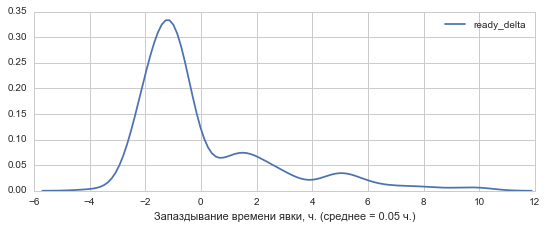

In [791]:
real_pres = team_info[team_info.state.isin(['1', '2', '5'])][['team', 'presence', 'presence_norm']]
a = team_plan[(team_plan.state == 2) & (team_plan.team.isin(real_pres.team))].drop_duplicates('team')
real_pres_fail = a[a.time_start != a.presence][['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']]
if real_pres_fail.empty:
    add_header('Для всех бригад в состояниях 1, 2, 5 явки запланированы верно')
else:
    add_header('Всего %d бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:' 
               % real_pres_fail.team.count())
    add_line(real_pres_fail.head(10))
    add_line('\nРаспределение по состояниям:')
    add_line(real_pres_fail.state_info.value_counts())
    team_id = real_pres_fail.iloc[0].team
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    add_line(team_plan[team_plan.team == team_id][cols])
    real_pres_fail['ready_delta'] = real_pres_fail.time_start - real_pres_fail.presence
    fig = plt.figure(figsize=(8, 3))    
    #fig = plt.figure()
    sns.set(style='whitegrid', context='notebook')
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team125_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

Для бригад в начальных состояниях 6 (прибыла на станцию с локомотивом), 7 (прибыла на станцию пассажиром), 9 (сдача локомотива) проверяем, запланирован ли далее для бригады отдых. Если отдых запланирован, то не сравниваем время явки с исходным - оно будет задано вновь после отдыха. Если отдых не запланирован, то явка должна быть возвращена.

Для всех бригад в состояниях 6, 7, 9 запланированы требуемые явки

Всего 14 бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200105527  1471411848  Aug 17, 08:30          6  1471356000  Aug 16, 17:00
 200200189739  1471393238  Aug 17, 03:20          6  1471335600  Aug 16, 11:20
 200200261246  1471386000  Aug 17, 01:20          6  1471317600  Aug 16, 06:20
 200200222012  1471393464  Aug 17, 03:24          6  1471346700  Aug 16, 14:25
 200200118641  1471383398  Aug 17, 00:36          6  1471330800  Aug 16, 10:00

Распределение по состояниям:
6    14
         team    st_from_name      st_to_name   time_start_f     time_end_f  state          loco
 200200105527     СМОЛЯНИНОВО     СМОЛЯНИНОВО  Aug 16, 17:00  Aug 16, 18:30      2            -1
 200200105527         УГЛОВАЯ  АМУРСКИЙ ЗАЛИВ  Aug 17, 03:50  Aug 17, 03:59      1  200200075849
 200200105527  АМУРСКИЙ ЗАЛИВ    НАДЕЖ

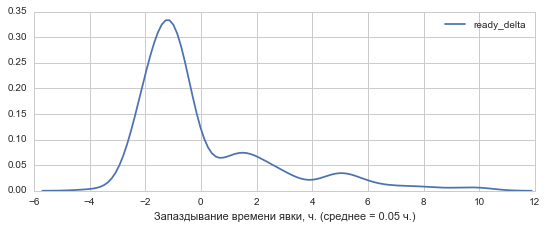

In [792]:
real_pres = team_info[team_info.state.isin(['6', '7', '9'])]
tp = team_plan[(team_plan.team.isin(real_pres.team)) & (team_plan.all_states.apply(lambda x: 4 not in x))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 6, 7, 9 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    
tp_ready_time_fail = tp[(tp.state == 2) & (tp.time_start != tp.presence)].drop_duplicates('team')
if tp_ready_time_fail.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 явки запланированы верно')
else:
    add_header('\nВсего %d бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:' 
               % tp_ready_time_fail.team.count())
    cols = ['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']
    add_line(tp_ready_time_fail[cols].head())
    add_line('\nРаспределение по состояниям:')
    add_line(tp_ready_time_fail.state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_ready_time_fail.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    fig = plt.figure(figsize=(8, 3))            
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team679_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

In [793]:
tp = team_plan[(team_plan.state_info.isin(['3', '4'])) & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 3, 4 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 3, 4 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для всех бригад в состояниях 3, 4 запланированы требуемые явки


In [794]:
tp = team_plan[(team_plan.team_type == 'Фейковая') & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех фейковых бригад запланированы требуемые явки')
else:
    add_header('Для %d фейковых бригад не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())        
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для 176 фейковых бригад не запланированы явки. Примеры:
         team loc_name state_info all_states
 777700002835      NaN        NaN        [1]
 777700002834      NaN        NaN        [1]
 777700002833      NaN        NaN        [1]
 777700002832      NaN        NaN        [1]
 777700002839      NaN        NaN        [1]
         team     st_from_name       st_to_name   time_start_f     time_end_f  state          loco
 777700002835           МОГОЧА           АМАЗАР  Aug 17, 17:00  Aug 17, 18:59      1  200200097356
 777700002835           АМАЗАР  ЕРОФЕЙ ПАВЛОВИЧ  Aug 17, 18:59  Aug 17, 21:18      1  200200097356
 777700002835  ЕРОФЕЙ ПАВЛОВИЧ            УРУША  Aug 17, 21:18  Aug 17, 23:23      1  200200097356
 777700002835            УРУША        БАМОВСКАЯ  Aug 17, 23:23  Aug 18, 00:46      1  200200097356
 777700002835        БАМОВСКАЯ          ГОРЕЛЫЙ  Aug 18, 00:46  Aug 18, 00:53      1  200200097356
 777700002835          ГОРЕЛЫЙ      СКОВОРОДИНО  Aug 18, 00:53  Aug 18, 01:32   

[ToC](#toc)
## Проверка планирования УТХ бригад

Если для какого-то депо приписки переданы бригады с признаком `uth(1)`, то такие бригады должны планироваться в первую очередь, и только после них должны планироваться бригады с признаком `uth(0)`. Для бригад с признаком `uth(0)` должен производиться сдвиг явки на время после максимального времени явки бригад с `uth(1)` для данного депо. Если бригад с `uth(1)` для данного депо не передано, то сдвиг производить не требуется.

In [795]:
add_header('Проверка планирования УТХ-бригад', h=2, p=False)

<a id='cmp_depart_uth'></a>
### УТХ-бригады должны планироваться раньше не-УТХ бригад, начальное состояние которых = 3

In [796]:
print(nice_time(current_time))
uth_depots = team_info[team_info.uth == 1].depot.unique()
cols = ['team', 'depot_name', 'uth', 'time_start_f', 'state']

t_ready_max = team_info[(team_info.uth == 1)].groupby('depot').presence.max()
t_plan_max = team_plan[(team_plan.uth == 1) 
                       & (team_plan.state.isin([0, 1]))].drop_duplicates('team').groupby('depot').time_start.max()
team_plan['uth_plan_max_time'] = team_plan.depot.map(t_plan_max)
team_plan['uth_plan_max_time_f'] = team_plan.uth_plan_max_time.apply(nice_time)
team_plan['uth_ready_max_time'] = team_plan.depot.map(t_ready_max)
team_plan['uth_ready_max_time_f'] = team_plan.uth_ready_max_time.apply(nice_time)
cols = ['team', 'depot_name', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 
        'uth_plan_max_time_f', 'uth_ready_max_time_f']
t_uth_soft_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_plan_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')
t_uth_hard_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_ready_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')

total_uth_depots = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') 
                             & (team_plan.depot.isin(uth_depots))].team.drop_duplicates().count()

t_uth_fail_diff_depot_n = t_uth_soft_fail[t_uth_soft_fail.depot_name != t_uth_soft_fail.st_from_name].team.count()

if t_uth_soft_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней УТХ-бригады' 
               % (t_uth_soft_fail.team.count(), 100 * t_uth_soft_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_soft_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_soft_fail[t_uth_soft_fail.depot_name == t_uth_soft_fail.st_from_name].head(10)[cols])    

Aug 16, 19:31
Всего 159 не-УТХ-бригад (24.31%), которые отправлены ранее самой поздней УТХ-бригады
-- из них 4 бригад, у которых место явки не совпадает с депо приписки

Распределение по депо (первые 5):
ЧИТА I                   21
МОГОЧА                   20
СМОЛЯНИНОВО              20
ИРКУТСК-СОРТИРОВОЧНЫЙ    20
ХАБАРОВСК II             12
НИЖНЕУДИНСК              12
РУЖИНО                   10
ЗИМА                      8
ВИХОРЕВКА                 8
ТАЙШЕТ                    7

Примеры бригад (первые 10 по времени отправления):
         team           depot_name         st_from_name   st_to_name   time_start_f  state uth_plan_max_time_f uth_ready_max_time_f
 200200216511  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...    ГОНЧАРОВО  Aug 18, 01:29      1       Aug 18, 06:31        Aug 17, 17:51
 200200164060  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...    ГОНЧАРОВО  Aug 17, 23:50      1       Aug 18, 06:31        Aug 17, 17:51
 200200251162            ВИХОРЕВКА            ВИХОРЕВКА     МОРГУДОН

In [797]:
if t_uth_hard_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше явки УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней явки УТХ-бригады' 
               % (t_uth_hard_fail.team.count(), 100 * t_uth_hard_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_hard_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_hard_fail[t_uth_hard_fail.depot_name == t_uth_hard_fail.st_from_name].head(10)[cols])    

Нет случаев, когда не-УТХ-бригада планируется раньше явки УТХ-бригады


### Проверка УТХ-бригад по одной станции

Составляется список всех УТХ-бригад по одной станции (по умолчанию - Иркутск-Сортировочный), подсчитывается, сколько таких бригад вообще не было использовано в планировании (это количество должно быть около нуля). Для дальнейшей проверки составляется список локомотивов, которые были отправлены с этой станции с фейковой бригадой или вообще без бригады. Дальше в том случае, если есть подвязки фейковых бригад и есть неиспользованные УТХ-бригады, то надо дополнительно по логам проверять, почему не была испоьзована УТХ-бригада.

In [798]:
st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
#st_name = 'СЛЮДЯНКА I'

In [799]:
add_header('Проверка УТХ-бригад по депо %s' % st_name, h=2, p=False)

In [800]:
team_info['depot_name'] = team_info.depot.map(st_names.name)

#team_info.columns
team_info['plan_start_time'] = team_info.team\
                        .map(team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)

In [801]:
irk_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 1)]
add_header('Все УТХ-бригады из депо %s (%d):' % (st_name, irk_uth.team.count()))
cols = ['team', 'depot_name', 'uth', 'state', 'is_assign', 'presence_norm', 'plan_start_time_f', 'prev_ready_time_f']
pd.set_option('display.max_colwidth', 30)
add_line(irk_uth.sort_values('presence')[cols])
t_max = irk_uth.presence.max()
t_plan_max = irk_uth.plan_start_time.max()
add_line('Максимальное время явки УТХ-бригад депо %s: %s' % (st_name, nice_time(t_max)))
add_line('Максимальное время отправления УТХ-бригад депо %s: %s' % (st_name, nice_time(t_plan_max)))
add_line('Всего УТХ-бригад: %d' % irk_uth.team.count())
add_line('Из них не использовано в планировании: %d' % irk_uth[irk_uth.is_assign == False].team.count())

Все УТХ-бригады из депо ИРКУТСК-СОРТИРОВОЧНЫЙ (30):
         team             depot_name  uth state is_assign  presence_norm plan_start_time_f prev_ready_time_f
 200200219086  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     0     False  Aug 16, 09:05                       Aug 16, 09:51
 200200126979  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     1      True  Aug 16, 10:40     Aug 16, 18:29     Aug 16, 11:19
 200200164617  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     1      True  Aug 16, 17:11     Aug 16, 19:17                  
 200200135984  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     3      True  Aug 16, 18:00     Aug 16, 22:48     Aug 16, 21:48
 200200275629  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     3      True  Aug 16, 18:00     Aug 16, 21:15                  
 200200093409  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     3      True  Aug 16, 18:00     Aug 17, 19:25     Aug 17, 16:25
 200200195786  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     3      True  Aug 16, 18:00     Aug 16, 21:10                  
 200200140065  ИРКУТСК-СОРТИРОВОЧНЫЙ    1     3      True  Aug 16, 18:00    

In [802]:
cols = ['team', 'depot_name', 'depot_st_name', 'uth', 'state', 'loc_name', 'is_assign', 'presence_norm', 'plan_start_time_f']
irk_no_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 0) & (team_info.state == '3')]
# add_header('Начальное расположение не-УТХ-бригад депо приписки %s в начальном состоянии 3:' % st_name)
# add_line(irk_no_uth.loc_name.value_counts())

In [803]:
add_line('Проверка на то, что не-УТХ-бригады, находившиеся в Иркутске, запланированы к отправлению НЕ РАНЕЕ '
        + 'максимального времени явки иркутских УТХ-бригад:')
add_line(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_max)
add_line('Проверка на то, что не-УТХ-бригады, находившиеся в Иркутске, запланированы к отправлению НЕ РАНЕЕ '
        + 'максимального времени отправления иркутских УТХ-бригад:')
add_line(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_plan_max)

Проверка на то, что не-УТХ-бригады, находившиеся в Иркутске, запланированы к отправлению НЕ РАНЕЕ максимального времени явки иркутских УТХ-бригад:
True
Проверка на то, что не-УТХ-бригады, находившиеся в Иркутске, запланированы к отправлению НЕ РАНЕЕ максимального времени отправления иркутских УТХ-бригад:
False


In [804]:
team_plan['fake_depot'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])]
                                             .drop_duplicates('team').set_index('team').st_from_name)
team_plan.depot_name.fillna(team_plan.fake_depot, inplace=True)

In [805]:
cols = ['team', 'st_from_name', 'loc_name', 'state', 'presence_norm', 'time_start_f', 'uth', 'delta']
team_plan['delta'] = team_plan.time_start - team_plan.presence
tp = team_plan[(team_plan.depot_name == st_name) 
          & (team_plan.state_info == '3') 
          & (team_plan.state.isin([0, 1]))
          & (team_plan.loc_name == st_name)]
add_header('Все запланированные бригады, отправленные со станции %s из начального state = 3 (всего %d):' 
           % (st_name, tp.drop_duplicates('team').team.count()))
add_line(tp.drop_duplicates('team').sort_values('time_start')[cols])

add_header('\nСреднее время (в часах) между явкой и отправлением для бригад депо %s (по типу - УТХ/не-УТХ):' % st_name)
add_line(np.round(tp.drop_duplicates('team').groupby('uth').delta.median() / 3600, 2))

Все запланированные бригады, отправленные со станции ИРКУТСК-СОРТИРОВОЧНЫЙ из начального state = 3 (всего 44):
         team           st_from_name               loc_name  state  presence_norm   time_start_f  uth   delta
 200200195786  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 16, 18:00  Aug 16, 21:10    1   11400
 200200275629  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 16, 18:00  Aug 16, 21:15    1   11700
 200200135984              ГОНЧАРОВО  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 16, 18:00  Aug 16, 22:48    1   17280
 200200185651  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 17, 00:00  Aug 17, 03:48    1   13680
 210213779354  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 16, 21:40  Aug 17, 04:20    1   23988
 210213563777  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 17, 00:40  Aug 17, 07:05    1   23088
 200200140065  ИРКУТСК-СОРТИРОВОЧНЫЙ  ИРКУТСК-СОРТИРОВОЧНЫЙ      1  Aug 16, 18:00  Aug 17, 07:50    1   49800
 20020022

In [806]:
loco_plan['team_start'] = loco_plan.team != loco_plan.team.shift(1)
loco_plan['team_depot'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_name)
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'team', 'team_depot']
no_team = loco_plan[(loco_plan.team_start == True) & (loco_plan.st_from_name == st_name) & (loco_plan.state.isin([0, 1]))
          & (loco_plan.time_start >= current_time) & (loco_plan.time_start < current_time + 24 * 3600)
          & ((loco_plan.team_type == 'Фейковая') | (loco_plan.team_type.isnull()))].sort_values('time_start')
add_header('Случаи отправки локомотива со станции %s без бригады или с фейковой бригадой (всего %d):'
          % (st_name, no_team.loco.count()))
add_line(no_team[cols])

Случаи отправки локомотива со станции ИРКУТСК-СОРТИРОВОЧНЫЙ без бригады или с фейковой бригадой (всего 5):
         loco           st_from_name  st_to_name   time_start_f          team   team_depot
 200214794947  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО  Aug 17, 10:00  777700001884   СЛЮДЯНКА I
 200200101969  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО  Aug 17, 11:15  777700001987   СЛЮДЯНКА I
 200200102229  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО  Aug 17, 14:25  777700002087   СЛЮДЯНКА I
 200200097847  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО  Aug 17, 15:05  777700001989   СЛЮДЯНКА I
 200200060802  ИРКУТСК-СОРТИРОВОЧНЫЙ  БАТАРЕЙНАЯ  Aug 17, 17:40  777700001621  НИЖНЕУДИНСК


In [807]:
linked = pd.read_csv(FOLDER + 'linked_stations.csv', dtype={'main':str, 'linked':str})
linked['main_name'] = linked.main.map(st_names.name)
linked['linked_name'] = linked.linked.map(st_names.name)
linked.dropna(inplace=True)

In [808]:
slot_pass = pd.read_csv(FOLDER + 'slot_pass.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot_pass)
cols = ['slot', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f']
slot_pass[(slot_pass.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ') & (slot_pass.st_to_name == 'ВОЕННЫЙ ГОРОДОК')
         & (slot_pass.time_start >= current_time) & (slot_pass.time_start < current_time + 24 * 3600)]\
        .sort_values('time_start')[cols]
slot_pass[slot_pass.slot == 200253805879][cols]

,slot,st_from_name,st_to_name,time_start_f,time_end_f


### Для бригад из депо, по которым нет УТХ-бригад, не должно быть большого сдвига времени явки

Составляется список всех бригад, принадлежащих тем депо приписки, по которым не было передано УТХ-бригад. Для таких бригад оценивается время между явкой и запланированным отправлением. Если 75%-квантиль распределения этих времен ожидания меньше 5 часов, то тест считается пройденным (значит, 75% таких бригад ожидали отправления не более 5 часов). В противном случае выдается предупреждение: время ожидания выглядит завышенным, нужна дополнительная проверка по логам.

In [809]:
team_plan['depot_time_f'] = team_plan.depot_time.apply(nice_time)
ts = team_plan[(team_plan.uth == 0) & (team_plan.depot.isin(uth_depots) == False) & (team_plan.state_info == '3')].copy()
ts['delta'] = ts.time_start - ts.depot_time
cols = ['team', 'st_from_name', 'loc_name', 'depot_name', 'depot_time_f', 'time_start_f', 'delta']
ts.drop_duplicates('team')[cols]
delta75 = (ts.drop_duplicates('team').delta / 3600).describe()['75%']
if delta75 < 5:
    add_header('У 75% бригад из депо, по которым нет УТХ-бригад, разница между переданным и запланированным временем явки'
              + ' составляет меньше %.2f ч. (это ОК)' % delta75)
else:
    add_header('WARNING: разница между планируемым и переданным временем явки у бригад из депо, по которым нет УТХ-бригад ' +
              'выглядит завышенной')
    add_line(ts[ts.delta > 5].sort_values('delta', ascending=False).head(10)[cols])

         team  st_from_name      loc_name depot_name   depot_time_f   time_start_f   delta
 200200267659     МАГДАГАЧИ     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:55  Aug 18, 08:14  141586
 200200166359  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:00  Aug 18, 06:39  139167
 200200260629  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:19  Aug 18, 06:38  137993
 200200174920     БЕЛОГОРСК  БЕЛОГОРСК II  БЕЛОГОРСК  Aug 16, 18:20  Aug 18, 08:30  137459
 200200166359  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:00  Aug 18, 05:59  136755
 200200248916  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 15:45  Aug 18, 05:28  135804
 200200260629  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:19  Aug 18, 05:58  135581
 200200167965  БЕЛОГОРСК II     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:29  Aug 18, 05:59  135055
 200200260629     БЕЛОГОРСК     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:19  Aug 18, 05:27  133716
 200200166359     БЕЛОГОРСК     БЕЛОГОРСК  БЕЛОГОРСК  Aug 16, 16:00  Aug 18, 05:07  133678

## Экспорт в HTML [ToC](#toc)

In [810]:
filename = REPORT_FOLDER + 'team_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/team_report_20160817_170911.html
